<a id="top"></a> 

## *Predicting Housing Prices for New York City*

<br>

#### ***by* [Sebastian Einar Røkholt](), [Eivind Tan Bertelsen](), <br>
&nbsp; &nbsp; &nbsp; &nbsp; [Kristian Hagen Risberg]() and [Peter Malum Bergerud]()**

> Spring 2021
> Course project for INFO284: Machine Learning
<br>

----------------------------------------------------------------------------

<br>

*Dataset available at [Kaggle.com](https://www.kaggle.com/new-york-city/nyc-property-sales).*
<br>

### Notebook Index (preliminary):
1. [**Introduction**](#intro)<br>

2. [**Inital Setup, Data Cleanup and Inspection**](#setup)<br>

3. [**Feature Engineering and Exploratory Data Analysis**](#analysis)<br>

4. [**Modelling**](#Modelling)<br>
    4.1       [*Linear Regression*](#linear-regression) <br>
    4.2       [*Support Vector Machines*](#svm) <br>
    4.3       [*Gradient Boosting with XGBoost*](#xgboost) <br>
    4.4       [*Neural Network: Multilayered Perceptron*](#mlp) <br>

5. [**Final Evaluation and Conclusions**](#test-eval) <br>

6. [**References**](#ref) <br>


### <a id="intro"></a>1) Introduction

Our aim with this machine learning project is to develop a model that can predict sale prices for properties in New York City. We will be using the [NYC Property Sales dataset](https://www.kaggle.com/new-york-city/nyc-property-sales), which contains data about 83,783 properties sold over a 12 month period in 2016 and 2017. We will experiment with four different families of algorithms in order to find the best one for this task: Linear Regression, Support Vector Machines (SVM), Extreme Gradient Boosting (XGBoost) and a neural network. 

## <a id="setup"></a>2) Inital Setup, Data Cleanup and Inspection


#### 2.1) Setup, importing dependencies and the dataset

In [3]:
# ----------------------------------- NOTEBOOK SETUP --------------------------------------------------------- #
# Installing dependencies
import sys
!{sys.executable} -m pip install xgboost # For installing XGBoost in Jupyter Notebook

# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, QuantileTransformer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_squared_error as MSE
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from xgboost import plot_importance
from math import sqrt
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.simplefilter(action='ignore', category=FutureWarning)  # For bug with sns distplot
warnings.filterwarnings(action='ignore', category=DataConversionWarning)  # For running models with a lot of iterations in Colab
pd.options.mode.chained_assignment = None  # Removes false positive SettingWithCopyWarning

# Setting global random state variable
random_state = 42

In [4]:
# Download dataset through Google Drive
data_link = "https://drive.google.com/uc?export=download&id=1GHrQ65qNYE4dez8LxCVTeVBA-nVLJwoN"

# Converting dataset to Pandas DataFrame
df = pd.read_csv(data_link)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

#### 2.2) Converting data types

In [5]:
# Displaying the five first rows of the data set
df.head(5)

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [6]:
# Display the shape, data type
print(f"Dataset shape: {df.shape[0]} rows, {df.shape[1]} columns")
df.dtypes

Dataset shape: 84548 rows, 22 columns


Unnamed: 0                         int64
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

The dataset consists of 85458 samples and 22 features of type object or integer. The features need to be converted to a more appropriate data type before further processing. 

In [7]:
# 'Building Class at Category' is object, should be categorical
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].astype('category')

# 'Tax Class at Present' is object, should be categorical
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')

# 'Building Class at Present' is object, should be categorical
df['BUILDING CLASS AT PRESENT'] = df['BUILDING CLASS AT PRESENT'].astype('category')

# 'Tax Class at Time of Sale' is dtype int, should be category
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')

# 'Building Class at Time of Sale' is object, should be categorical
df['BUILDING CLASS AT TIME OF SALE'] = df['BUILDING CLASS AT TIME OF SALE'].astype('category')

# 'Sale Price' is object, should be numeric (int/float)
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

# 'Sale Date' is dtype object but should be datetime
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')

# 'Land Square Feet' and  'Gross Square Feet' are dtype object but should be numeric
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

In [8]:
df.dtypes

Unnamed: 0                                 int64
BOROUGH                                    int64
NEIGHBORHOOD                              object
BUILDING CLASS CATEGORY                 category
TAX CLASS AT PRESENT                    category
BLOCK                                      int64
LOT                                        int64
EASE-MENT                                 object
BUILDING CLASS AT PRESENT               category
ADDRESS                                   object
APARTMENT NUMBER                          object
ZIP CODE                                   int64
RESIDENTIAL UNITS                          int64
COMMERCIAL UNITS                           int64
TOTAL UNITS                                int64
LAND SQUARE FEET                         float64
GROSS SQUARE FEET                        float64
YEAR BUILT                                 int64
TAX CLASS AT TIME OF SALE               category
BUILDING CLASS AT TIME OF SALE          category
SALE PRICE          

#### 2.3) Handling missing and duplicate values

In [9]:
# Find the number of missing values
print(df.isna().sum())

Unnamed: 0                            0
BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE-MENT                             0
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
APARTMENT NUMBER                      0
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                  26252
GROSS SQUARE FEET                 27612
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                        14561
SALE DATE                             0
dtype: int64


In [10]:
# Display statistical information about the distribution of the numerical variables
df.describe()

,Unnamed: 0,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,84548.000000,5.829600e+04,5.693600e+04,84548.000000,6.998700e+04
mean,10344.359878,2.998758,4237.218976,376.224015,10731.991614,2.025264,0.193559,2.249184,3.941676e+03,4.045707e+03,1789.322976,1.276456e+06
std,7151.779436,1.289790,3568.263407,658.136814,1290.879147,16.721037,8.713183,18.972584,4.198397e+04,3.503249e+04,537.344993,1.140526e+07
min,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,4231.000000,2.000000,1322.750000,22.000000,10305.000000,0.000000,0.000000,1.000000,1.650000e+03,1.046750e+03,1920.000000,2.250000e+05
50%,8942.000000,3.000000,3311.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.325000e+03,1.680000e+03,1940.000000,5.300000e+05
75%,15987.250000,4.000000,6281.000000,1001.000000,11357.000000,2.000000,0.000000,2.000000,3.500000e+03,2.560000e+03,1965.000000,9.500000e+05
max,26739.000000,5.000000,16322.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


There are a lot of missing values in the dataset. Most of the features have a minimum value of 0, which also doesn't make sense for features such as `ZIP CODE`, `YEAR BUILT` or `LAND SQUARE FEET`. These values are likely errors and will need to be handled appropriately. 

Other missing values are denoted as strings such as whitespace.  We will replace these with `np.NaN` by using a regular expression.

In [11]:
# Replace incorrect Zip Code values with np.NaN
df['ZIP CODE'] = df['ZIP CODE'].replace(to_replace=0, value=np.NaN)

# Replace incorrect values for Land and Gross Square Feet with np.NaN
df[['LAND SQUARE FEET', 'GROSS SQUARE FEET']] = df[['LAND SQUARE FEET', 'GROSS SQUARE FEET']].replace(to_replace=0, value=np.NaN)

# Replace incorrect values for Year Built with np.NaN
df['YEAR BUILT'] = df['YEAR BUILT'].replace(to_replace=0, value=np.NaN)

# Replace various string notations of missing values with np.NaN
df = df.replace(to_replace=r'(^\s+$|^\s*-|^`$)', value=np.NaN, regex=True)


Some samples have a `TOTAL UNITS` of 0, or a `TOTAL UNITS` value which is not equal to the value of `RESIDENTIAL UNITS` + `COMMERCIAL UNITS`. We therefore want to re-calculate the values for this feature to ensure that the value is at least equal to 1. 


In [12]:
# Recalculating Total Units
df['TOTAL UNITS'] = df['COMMERCIAL UNITS'] + df['RESIDENTIAL UNITS']

# We know that each property has to have at least 1 unit in total.
# If Total Units is still set to 0 after recalculation, set it to 1
for index, row in df.iterrows():
    if row['TOTAL UNITS'] == 0:
        df.loc[index, 'TOTAL UNITS'] = 1

In [13]:
# Display each feature's number and proportion of missing values
missing = pd.DataFrame(df.isna().sum(), columns=['Missing count'])
missing["% missing out of total"] = round(df.isna().sum()/len(df), 4)
missing

,Missing count,% missing out of total
Unnamed: 0,0,0.0000
BOROUGH,0,0.0000
NEIGHBORHOOD,0,0.0000
BUILDING CLASS CATEGORY,0,0.0000
TAX CLASS AT PRESENT,0,0.0000
BLOCK,0,0.0000
LOT,0,0.0000
EASE-MENT,84548,1.0000
BUILDING CLASS AT PRESENT,0,0.0000
ADDRESS,0,0.0000


The `EASEMENT` feature contains only missing values, while `Unnamed: 0` seems to be an iterator that marks the indeces from the original source of the dataset. These two features are useless and should therefore be removed from the dataframe. 

In [14]:
# Remove Easement and iterator features
df.drop(columns=['EASE-MENT', 'Unnamed: 0'], axis=1, inplace=True)

`BUILDING CLASS AT PRESENT` and `TAX CLASS AT PRESENT` are mostly identical to the `TAX CLASS AT TIME OF SALE` and `BUILDING CLASS AT TIME OF SALE` features, with the only difference being that the `-AT PRESENT` features might have been updated since the time of sale. Since we are only interested in predicting property prices at the time of sale, the `-AT PRESENT` features can be deleted.

In [15]:
# Remove features `TAX CLASS AT PRESENT` and `BUILDING CLASS AT PRESENT`
df.drop(columns=['TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT'], inplace=True)

In [16]:
# Display the no. of duplicated rows
print(df.duplicated().sum())

765


Next, we remove 765 duplicated rows. 

In [17]:
# Drop duplicate rows from dataframe
print(f"Original shape: {df.shape}")
df = df.drop_duplicates(keep='first')
print(f"New shape after removing duplicate rows: {df.shape}")

Original shape: (84548, 18)
New shape after removing duplicate rows: (83783, 18)


In [18]:
# Display each feature's number and proportion of missing values again
print("\n\nNo. of missing values after deleting useless features and duplicated samples")
missing = pd.DataFrame(df.isna().sum(), columns=['Missing count'])
missing["% missing out of total"] = round(df.isna().sum()/len(df), 4)
missing



No. of missing values after deleting useless features and duplicated samples


,Missing count,% missing out of total
BOROUGH,0,0.0000
NEIGHBORHOOD,0,0.0000
BUILDING CLASS CATEGORY,0,0.0000
BLOCK,0,0.0000
LOT,0,0.0000
ADDRESS,0,0.0000
APARTMENT NUMBER,64936,0.7750
ZIP CODE,971,0.0116
RESIDENTIAL UNITS,0,0.0000
COMMERCIAL UNITS,0,0.0000


17% of the values for `SALE PRICE` are missing. The documentation for the dataset states that missing values or very low values for sale price is due to sales where there was a transfer of ownership without a cash consideration. We are not interested in using data for property sales where there was no cash consideration, because there is no way to learn the value of the property. We can therefore remove these samples. 

In [19]:
print(f"Shape before removing rows with missing target feature value: {df.shape}")

# Remove all rows with missing value for sale price feature
df.dropna(subset=['SALE PRICE'], axis=0, inplace=True)
print(f"Shape after removing rows with missing target feature value: {df.shape}")

Shape before removing rows with missing target feature value: (83783, 18)
Shape after removing rows with missing target feature value: (69607, 18)


There are 971 missing values for `ZIP CODE`. Since the dataframe is sorted by `BOROUGH` and `NEIGHBORHOOD` (in that order), it makes sense to simply fill missing zip code values with the zip code value observed in the preceding row. Zip codes are distributed in proximity, in such a way that sequential zip codes are often located next to each other. Even if the filled value is incorrect, it should be close to the real value and will therefore result in a minor error with little impact on model performance. 

In [20]:
# Filling missing `ZIP CODE` values by propagating the last valid observation forward
df['ZIP CODE'].fillna(value=None, method='ffill', inplace=True)

# Display each feature's number and proportion of missing values after handling missing zip code values
print("\n\nNumber of missing values in each column after after handling missing zip code values")
missing = pd.DataFrame(df.isna().sum(), columns=['Missing count'])
missing["% missing out of total"] = round(df.isna().sum()/len(df), 4)
missing



Number of missing values in each column after after handling missing zip code values


,Missing count,% missing out of total
BOROUGH,0,0.0000
NEIGHBORHOOD,0,0.0000
BUILDING CLASS CATEGORY,0,0.0000
BLOCK,0,0.0000
LOT,0,0.0000
ADDRESS,0,0.0000
APARTMENT NUMBER,54168,0.7782
ZIP CODE,0,0.0000
RESIDENTIAL UNITS,0,0.0000
COMMERCIAL UNITS,0,0.0000


Approximately a third of the values for the `LAND SQUARE FEET` and `GROSS SQUARE FEET` features are missing as well, along with ~7% of the values for `YEAR BUILT`. However, if there is a high correlation between `LAND SQUARE FEET` and `GROSS SQUARE FEET` we can remove one of the features from the dataset without losing too much information. This will also help combat any issues with multicollinearity, which can undermine the significancy of the independent variables in the dataset. 

However, before we calculate the correlation with the target feature we must make sure to split the dataset into training (70%), validation (15%) and test (15%) data. The test data represents data from the future that our final model is going to meet "in the wild", and should therefore only be used once on our best model. It is also important to avoid "information leakage" from the test set, which occurs when information from the test set "leaks" into the training data or otherwise influences which parameters or models are selected for further experimentation. We must therefore consistently fit scalers or other preprocessing estimators on the training set, and then use these to transform the validation and test sets. It is also important to note that only training data should be used to create visualizations, especially if those plots influence the rest of the process. After all, data from the "future" cannot influence the past! 

The validation set, on the other hand, will be used to evaluate each model and thus influence which parameters we choose and which model we test on the final test set. 



In [21]:
# Splitting the data into input features (X) and a single output/target feature (y)
X = df.drop("SALE PRICE", axis = 1)
y = df["SALE PRICE"]
print(X.shape)

(69607, 17)


In [22]:
# Splitting the dataset into train (70%), validation (15%) and test (15%)
# The test set is only used once at the end of the report, to evaluate the final model
X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, random_state=random_state, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, random_state=random_state, test_size=0.5)

X_train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BLOCK,LOT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
75763,4,WOODSIDE,02 TWO FAMILY DWELLINGS,1330,19,57-10 43RD AVENUE,NaN,11377.0,2,0,2,2466.0,2320.0,1930.0,1,B2,2016-12-02
64505,4,JACKSON HEIGHTS,13 CONDOS - ELEVATOR APARTMENTS,1469,1006,35-38 JUNCTION BOULEVARD,2C,11368.0,1,0,1,NaN,NaN,2006.0,2,R4,2017-08-28
41174,3,KENSINGTON,10 COOPS - ELEVATOR APARTMENTS,5305,51,"36-58 DAHILL ROAD, 5-J",NaN,11218.0,0,0,1,NaN,NaN,1950.0,2,D4,2017-07-24
63512,4,HOWARD BEACH,13 CONDOS - ELEVATOR APARTMENTS,11431,3104,151-15 84 STREET,1D,11414.0,1,0,1,NaN,NaN,1966.0,2,R4,2017-08-14
30284,3,BRIGHTON BEACH,10 COOPS - ELEVATOR APARTMENTS,8680,1,"40 BRIGHTON FIRST ROAD, 12H",NaN,11235.0,0,0,1,NaN,NaN,1963.0,2,D4,2017-04-27


In [23]:
y_train[:5]

75763    1065000.0
64505     520000.0
41174     441079.0
63512     285000.0
30284          0.0
Name: SALE PRICE, dtype: float64

In [24]:
# Check correlation between Land Square Feet and Gross Square Feet
print('corr between gross and land square feet: ', X_train['GROSS SQUARE FEET'].corr(X_train['LAND SQUARE FEET']))

# Check correlation between Land Square Feet, Gross Square Feet and Sale Price
print('corr between gross square feet and sale price: ', X_train['GROSS SQUARE FEET'].corr(y_train))
print('corr between land square feet and sale price: ', X_train['LAND SQUARE FEET'].corr(y_train))

corr between gross and land square feet:  0.6873735713233126
corr between gross square feet and sale price:  0.3941353485170718
corr between land square feet and sale price:  0.08996237652004829


In [25]:
# Drop feature LAND SQUARE FEET from training, validation and test data 
# as it has very low correlation with target variable 
X_train.drop(labels='LAND SQUARE FEET', axis=1, inplace=True)
X_val.drop(labels='LAND SQUARE FEET', axis=1, inplace=True)
X_test.drop(labels='LAND SQUARE FEET', axis=1, inplace=True)
X_train.head(5)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,BLOCK,LOT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
75763,4,WOODSIDE,02 TWO FAMILY DWELLINGS,1330,19,57-10 43RD AVENUE,NaN,11377.0,2,0,2,2320.0,1930.0,1,B2,2016-12-02
64505,4,JACKSON HEIGHTS,13 CONDOS - ELEVATOR APARTMENTS,1469,1006,35-38 JUNCTION BOULEVARD,2C,11368.0,1,0,1,NaN,2006.0,2,R4,2017-08-28
41174,3,KENSINGTON,10 COOPS - ELEVATOR APARTMENTS,5305,51,"36-58 DAHILL ROAD, 5-J",NaN,11218.0,0,0,1,NaN,1950.0,2,D4,2017-07-24
63512,4,HOWARD BEACH,13 CONDOS - ELEVATOR APARTMENTS,11431,3104,151-15 84 STREET,1D,11414.0,1,0,1,NaN,1966.0,2,R4,2017-08-14
30284,3,BRIGHTON BEACH,10 COOPS - ELEVATOR APARTMENTS,8680,1,"40 BRIGHTON FIRST ROAD, 12H",NaN,11235.0,0,0,1,NaN,1963.0,2,D4,2017-04-27



`GROSS SQUARE FEET` and `YEAR BUILT` might prove very valuable for price prediction, but these features have more than 33,000 missing values combined. Instead of removing them entirely, we want to predict these values with the K Nearest Neighbors algorithm by using Scikit-Learn's *KNNImputer* estimator. This method of handling missing data locates the $n$ most similar samples to a sample with missing values, and inserts ("imputes") the mean value for the neighbors into the missing row. It is not perfect, but since we have a lot of data we expect it to work well enough. We expect that keeping this many samples will substantially improve the accuracy of our models. 

As the KNNImputer calculates the euclidean distances to neighbors, it is important to scale the data first. We will therefore use QuantileTransformer to scale the data first. The effect of QuantileTransformer will be further explained in the section for the exploratory data analysis (EDA). 

In [26]:
# Concatenate X and y to a single dataframe in order to perform imputations
Xy_train = pd.concat(objs=[X_train, y_train], axis=1)
Xy_val = pd.concat(objs=[X_val, y_val], axis=1)
Xy_test = pd.concat(objs=[X_test, y_test], axis=1)

# Build the dataset to train the KNN Imputer. We only want to train based on a few features
imputer_train = Xy_train.loc[:, ['YEAR BUILT', 'GROSS SQUARE FEET', 
                                 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 
                                 'TOTAL UNITS', 'SALE PRICE']]
imputer_val = Xy_val.loc[:, ['YEAR BUILT', 'GROSS SQUARE FEET', 
                                 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 
                                 'TOTAL UNITS', 'SALE PRICE']]
imputer_test = Xy_test.loc[:, ['YEAR BUILT', 'GROSS SQUARE FEET', 
                                 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 
                                 'TOTAL UNITS', 'SALE PRICE']]

# Scale the data with QuantileTransformer, which is very robust towards outliers. 
scaler = QuantileTransformer()
imputer_train = scaler.fit_transform(imputer_train)
imputer_val = scaler.transform(imputer_val)
imputer_test = scaler.transform(imputer_test)

imputer_train[:5]

array([[0.36336336, 0.61711712, 0.8003003 , 0.        , 0.78428428,
        0.78433006],
       [0.88938939,        nan, 0.503003  , 0.        , 0.        ,
        0.48898899],
       [0.54404404,        nan, 0.        , 0.        , 0.        ,
        0.41871682],
       [0.73773774,        nan, 0.503003  , 0.        , 0.        ,
        0.29079079],
       [0.7017017 ,        nan, 0.        , 0.        , 0.        ,
        0.        ]])

In [27]:
# Instantiate the KNN Imputer object
imputer = KNNImputer(n_neighbors=9, weights='uniform')

# The KNN imputer is fitted on a subset of the features in the training data, 
# and is then used to transform the training, validation and test sets
train_imputed = imputer.fit_transform(imputer_train)
val_imputed = imputer.transform(imputer_val)
test_imputed = imputer.transform(imputer_test)

In [28]:
train_imputed[:5]

array([[0.36336336, 0.61711712, 0.8003003 , 0.        , 0.78428428,
        0.78433006],
       [0.88938939, 0.30866978, 0.503003  , 0.        , 0.        ,
        0.48898899],
       [0.54404404, 0.23585946, 0.        , 0.        , 0.        ,
        0.41871682],
       [0.73773774, 0.37677492, 0.503003  , 0.        , 0.        ,
        0.29079079],
       [0.7017017 , 0.37324808, 0.        , 0.        , 0.        ,
        0.        ]])

In [29]:
# Unscale the imputed data
train_imputed_unscaled = scaler.inverse_transform(train_imputed)
val_imputed_unscaled = scaler.inverse_transform(val_imputed)
test_imputed_unscaled = scaler.inverse_transform(test_imputed)

train_imputed_unscaled[:5]

array([[1.93000000e+03, 2.32000000e+03, 2.00000000e+00, 0.00000000e+00,
        2.00000000e+00, 1.06500000e+06],
       [2.00600000e+03, 1.54872222e+03, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 5.20000000e+05],
       [1.95000000e+03, 1.40000000e+03, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 4.41079000e+05],
       [1.96600000e+03, 1.69661375e+03, 1.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 2.85000000e+05],
       [1.96300000e+03, 1.68649935e+03, 0.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 0.00000000e+00]])

In [30]:
# Impute the predicted values into the dataset: Training data
X_train.loc[:, 'YEAR BUILT'] = train_imputed_unscaled[:,0]
X_train.loc[:, 'GROSS SQUARE FEET'] = train_imputed_unscaled[:,1]
print(X_train.shape)

# Impute the predicted values into the dataset: Validation data
X_val.loc[:, 'YEAR BUILT'] = val_imputed_unscaled[:,0]
X_val.loc[:, 'GROSS SQUARE FEET'] = val_imputed_unscaled[:,1]
print(X_val.shape)

# Impute the predicted values into the dataset: Test data
X_test.loc[:, 'YEAR BUILT'] = test_imputed_unscaled[:,0]
X_test.loc[:, 'GROSS SQUARE FEET'] = test_imputed_unscaled[:,1]
print(X_test.shape)

(48724, 16)
(10441, 16)
(10442, 16)


In [31]:
X_train.head(10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(48724, 16)
(10441, 16)
(10442, 16)


*After running a linear regression model on the dataset with and without KNN imputation, we found that KNN imputation increased $r^2$ of the baseline model of about 0.07*.

In [32]:
# Display each feature's number and proportion of missing values after imputing missing values for two features
# Concatenate X and y to a single dataframe again to include SALE PRICE
Xy_train = pd.concat(objs=[X_train, y_train], axis=1)
Xy_val = pd.concat(objs=[X_val, y_val], axis=1)
Xy_test = pd.concat(objs=[X_test, y_test], axis=1)

print("\n\nNumber of missing values in each column after after imputing missing values for two features")
missing = pd.DataFrame(Xy_train.isna().sum(), columns=['Missing count'])
missing["% missing out of total"] = round(Xy_train.isna().sum()/len(Xy_train), 4)
missing



Number of missing values in each column after after imputing missing values for two features


,Missing count,% missing out of total
BOROUGH,0,0.0000
NEIGHBORHOOD,0,0.0000
BUILDING CLASS CATEGORY,0,0.0000
BLOCK,0,0.0000
LOT,0,0.0000
ADDRESS,0,0.0000
APARTMENT NUMBER,37912,0.7781
ZIP CODE,0,0.0000
RESIDENTIAL UNITS,0,0.0000
COMMERCIAL UNITS,0,0.0000


Finally, `APARTMENT NUMBER` contains approximately 78% missing values and should therefore be deleted. There are also a two features in addition to `ZIP CODE` that indicate the property's geographical location: `BLOCK` and `LOT`. These values need to be interpreted in a specific sequence along with `BOROUGH`, and are therefore unsuitable for machine learning algorithms. Similarly, `ADDRESS` contains no numerical information that can be used and should also be removed.

In [33]:
# Dropping features: BLOCK, LOT, ADRESS and APARTMENT NUMBER.
Xy_train.drop(["BLOCK", "LOT", "ADDRESS", "APARTMENT NUMBER"], axis = 1, inplace=True)
Xy_val.drop(["BLOCK", "LOT", "ADDRESS", "APARTMENT NUMBER"], axis = 1, inplace=True)
Xy_test.drop(["BLOCK", "LOT", "ADDRESS", "APARTMENT NUMBER"], axis = 1, inplace=True)

#### 2.4) Removing incorrect values and reducing the amount of outliers for the target feature

In [34]:
# Summative statistics on the target feature after removing missing data
print(Xy_train['SALE PRICE'].describe(percentiles=[.05, .15, .2, .25, .5, .75, 0.9, .95, .99]))

# Display the 10 lowest unique sale price values 
unique_prices = Xy_train['SALE PRICE'].sort_values().unique()
print("\n\n Ten lowest unique sale prices, in USD: ", unique_prices[:10])

count    4.872400e+04
mean     1.264629e+06
std      7.902986e+06
min      0.000000e+00
5%       0.000000e+00
15%      1.000000e+01
20%      1.500000e+05
25%      2.300000e+05
50%      5.332175e+05
75%      9.500000e+05
90%      1.967688e+06
95%      3.525000e+06
99%      1.255000e+07
max      1.040000e+09
Name: SALE PRICE, dtype: float64


 Ten lowest unique sale prices, in USD:  [  0.   1.   2.   3.   5.  10.  19.  20. 100. 210.]


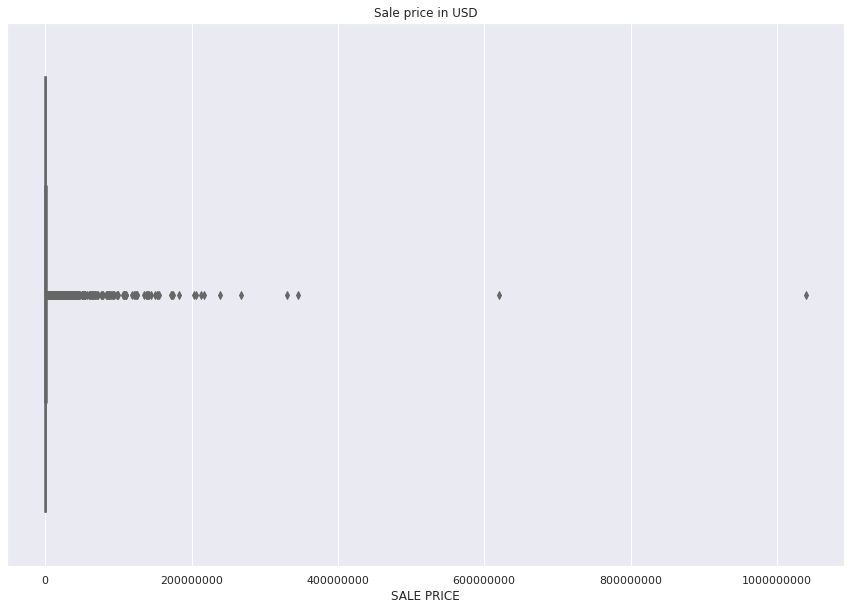

In [35]:
#Set the size of the plot
plt.figure(figsize=(15,10))
sns.set(style='darkgrid', context='notebook', palette='coolwarm') 

# Plot the data and configure the settings
sns.boxplot(x='SALE PRICE', data=Xy_train)
plt.ticklabel_format(style='plain', axis='x')
plt.title('Sale price in USD')
plt.show()

The target feature contains a lot of outliers, which is expected since the dataset contains both commercial and residential properties. There are however a lot of sale prices that don't accurately depict the actual value of the propery, due to the property transfer with low or no cash consideration. We must therefore attempt to remove outliers at the lower bound. We find it unrealistic that any properties in New York are sold at a price of less than $100,000, and will therefore remove samples accordingly.  

We want to keep as much data as possible, but it is unreasonable to include outliers above the 99th percentile even if we map the data to a normal distribution. Properties sold for prices higher than this exist in a niche market, and we simply do not have enough data on these kinds of sales in order to build a model suitable for predicting on it. We will therefore remove samples with a sale price above $12,500,500. 

In [36]:
# Remove samples where price is less than $100,000 
# and greater than the 99th percentile ($12,500,000)
Xy_train = Xy_train[(Xy_train['SALE PRICE'] > 100000) & (Xy_train['SALE PRICE'] < 12500000)]
Xy_val = Xy_val[(Xy_val['SALE PRICE'] > 100000) & (Xy_val['SALE PRICE'] < 12500000)]
Xy_test = Xy_test[(Xy_test['SALE PRICE'] > 100000) & (Xy_test['SALE PRICE'] < 12500000)]

print(Xy_train.shape)
print(Xy_val.shape)
print(Xy_test.shape)

(39413, 13)
(8445, 13)
(8390, 13)


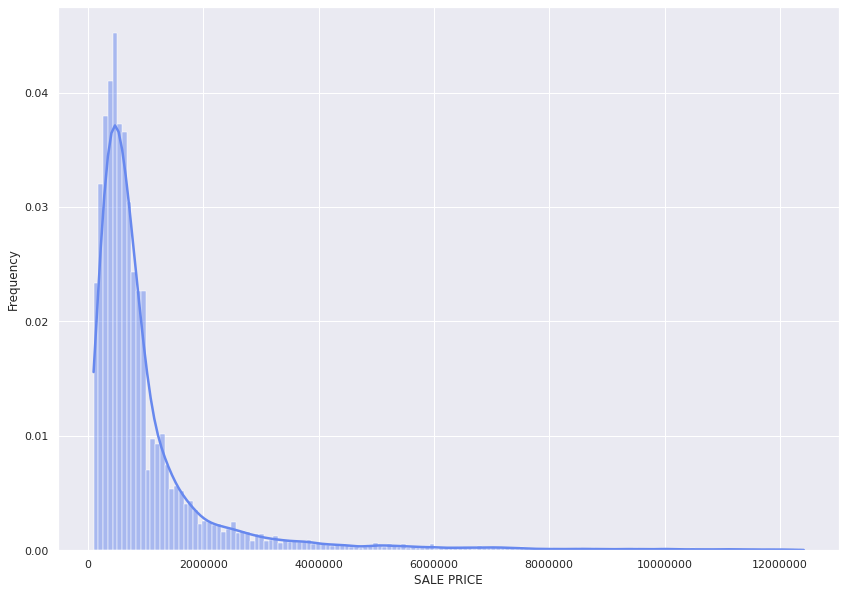

In [37]:
# Plot histogram of sale price after removing missing, incorrect and extreme outlier values
sns.set(style='darkgrid', context='notebook', palette='coolwarm') 
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
plt.figure(figsize=(14,10))
sns.histplot(Xy_train['SALE PRICE'], stat='frequency', bins=150, kde=True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

The histogram clearly that the distribution of the target feature is severely right-skewed. Unless the data is mapped to a Gaussian (normal) distribution, this skewness will negatively impact the predictions made by our machine learning models.

In [38]:
# Display each feature's number and proportion of missing values after 
# handling missing and incorrect values for target feature
print("\n\nNumber of missing values in each column after after handling missing\
values for target feature: ")
missing = pd.DataFrame(Xy_train.isna().sum(), columns=['Missing count'])
missing["% missing out of total"] = round(Xy_train.isna().sum()/len(Xy_train), 4)
missing



Number of missing values in each column after after handling missingvalues for target feature: 


,Missing count,% missing out of total
BOROUGH,0,0.0
NEIGHBORHOOD,0,0.0
BUILDING CLASS CATEGORY,0,0.0
ZIP CODE,0,0.0
RESIDENTIAL UNITS,0,0.0
COMMERCIAL UNITS,0,0.0
TOTAL UNITS,0,0.0
GROSS SQUARE FEET,0,0.0
YEAR BUILT,0,0.0
TAX CLASS AT TIME OF SALE,0,0.0


In [39]:
# The cleaned dataframe (training data) looks like this
print(f"Training dataframe shape: {Xy_train.shape}")
print(f"Validation dataframe shape: {Xy_val.shape}")
print(f"Test dataframe shape: {Xy_test.shape}")
Xy_train.head(10)

Training dataframe shape: (39413, 13)
Validation dataframe shape: (8445, 13)
Test dataframe shape: (8390, 13)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE,SALE PRICE
75763,4,WOODSIDE,02 TWO FAMILY DWELLINGS,11377.0,2,0,2,2320.000000,1930.0,1,B2,2016-12-02,1065000.0
64505,4,JACKSON HEIGHTS,13 CONDOS - ELEVATOR APARTMENTS,11368.0,1,0,1,1548.722222,2006.0,2,R4,2017-08-28,520000.0
41174,3,KENSINGTON,10 COOPS - ELEVATOR APARTMENTS,11218.0,0,0,1,1400.000000,1950.0,2,D4,2017-07-24,441079.0
63512,4,HOWARD BEACH,13 CONDOS - ELEVATOR APARTMENTS,11414.0,1,0,1,1696.613753,1966.0,2,R4,2017-08-14,285000.0
2701,1,FLATIRON,10 COOPS - ELEVATOR APARTMENTS,10016.0,0,0,1,3000.000000,1910.0,2,D4,2017-01-04,2260000.0
75445,4,WOODHAVEN,02 TWO FAMILY DWELLINGS,11421.0,2,0,2,1655.000000,1955.0,1,B1,2017-08-03,300000.0
2847,1,FLATIRON,13 CONDOS - ELEVATOR APARTMENTS,10010.0,1,0,1,3600.000000,1913.0,2,R4,2017-04-04,6669537.0
38561,3,FLATBUSH-LEFFERTS GARDEN,01 ONE FAMILY DWELLINGS,11225.0,1,0,1,1765.000000,1910.0,1,A4,2016-09-15,1425000.0
62338,4,HOLLIS,01 ONE FAMILY DWELLINGS,11412.0,1,0,1,1200.000000,1945.0,1,A2,2017-01-05,450000.0
83832,5,WEST NEW BRIGHTON,02 TWO FAMILY DWELLINGS,10310.0,2,0,2,1536.000000,1901.0,1,B2,2017-02-21,275000.0


## <a id="analysis"></a>3) Feature Engineering and Exploratory Data Analysis



We will now attempt to engineer 2 new features: `PROPERTY AGE` instead of `YEAR BUILT` and `SALE MONTH` instead of `SALE YEAR`. These features will provide more useful information that is easier for machine learning models to predict on. We will also perform One Hot Encoding of all categorical features in order to transform these to numerical values, which are more suitable for linear regression models and neural networks. 

#### <a id="property-age"></a>3.1) Converting the feature "YEAR BUILT" to something more useful


In [40]:
# Join training, validation and test data before one hot encoding
Xy_train['TRAINING DATA'] = 1
Xy_train['VALIDATION DATA'] = 0
Xy_train['TEST DATA'] = 0

Xy_val['TRAINING DATA'] = 0
Xy_val['VALIDATION DATA'] = 1
Xy_val['TEST DATA'] = 0

Xy_test['TRAINING DATA'] = 0
Xy_test['VALIDATION DATA'] = 0
Xy_test['TEST DATA'] = 1

# Concatenate training, validation and test data to a single frame for efficiency
# Does NOT mix training, validation and test data; however, 
# do not visualize anything else than the first few rows of this DataFrame!!
all_data = pd.concat([Xy_train, Xy_val, Xy_test])
all_data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE,SALE PRICE,TRAINING DATA,VALIDATION DATA,TEST DATA
75763,4,WOODSIDE,02 TWO FAMILY DWELLINGS,11377.0,2,0,2,2320.000000,1930.0,1,B2,2016-12-02,1065000.0,1,0,0
64505,4,JACKSON HEIGHTS,13 CONDOS - ELEVATOR APARTMENTS,11368.0,1,0,1,1548.722222,2006.0,2,R4,2017-08-28,520000.0,1,0,0
41174,3,KENSINGTON,10 COOPS - ELEVATOR APARTMENTS,11218.0,0,0,1,1400.000000,1950.0,2,D4,2017-07-24,441079.0,1,0,0
63512,4,HOWARD BEACH,13 CONDOS - ELEVATOR APARTMENTS,11414.0,1,0,1,1696.613753,1966.0,2,R4,2017-08-14,285000.0,1,0,0
2701,1,FLATIRON,10 COOPS - ELEVATOR APARTMENTS,10016.0,0,0,1,3000.000000,1910.0,2,D4,2017-01-04,2260000.0,1,0,0


In [41]:
# Extract the year the property was sold from the Sale Date column
all_data_sale_year = all_data['SALE DATE'].astype(str).str[:4]

# Calculate the property age
all_data['PROPERTY AGE'] = all_data_sale_year.astype(int) - all_data['YEAR BUILT']

# Remove the Year Built feature
all_data.drop('YEAR BUILT', axis=1, inplace=True)
all_data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE,SALE PRICE,TRAINING DATA,VALIDATION DATA,TEST DATA,PROPERTY AGE
75763,4,WOODSIDE,02 TWO FAMILY DWELLINGS,11377.0,2,0,2,2320.000000,1,B2,2016-12-02,1065000.0,1,0,0,86.0
64505,4,JACKSON HEIGHTS,13 CONDOS - ELEVATOR APARTMENTS,11368.0,1,0,1,1548.722222,2,R4,2017-08-28,520000.0,1,0,0,11.0
41174,3,KENSINGTON,10 COOPS - ELEVATOR APARTMENTS,11218.0,0,0,1,1400.000000,2,D4,2017-07-24,441079.0,1,0,0,67.0
63512,4,HOWARD BEACH,13 CONDOS - ELEVATOR APARTMENTS,11414.0,1,0,1,1696.613753,2,R4,2017-08-14,285000.0,1,0,0,51.0
2701,1,FLATIRON,10 COOPS - ELEVATOR APARTMENTS,10016.0,0,0,1,3000.000000,2,D4,2017-01-04,2260000.0,1,0,0,107.0


In [42]:
# Replace numerical values in 'BOROUGH' to actual names of the Bouroghs in NYC
all_data['BOROUGH'] = all_data['BOROUGH'].replace(
    to_replace={1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn',4: 'Queens', 5: 'Staten Island'})

In [43]:
# Finding all unique values for the different features 
features = ["BOROUGH","NEIGHBORHOOD","BUILDING CLASS CATEGORY", "ZIP CODE",
            "RESIDENTIAL UNITS", "COMMERCIAL UNITS", "TOTAL UNITS", "GROSS SQUARE FEET", "TAX CLASS AT TIME OF SALE",
            "BUILDING CLASS AT TIME OF SALE", "SALE PRICE", "SALE DATE", "PROPERTY AGE"]

for feature in features:
    print(feature,len(all_data[feature].unique()))

BOROUGH 5
NEIGHBORHOOD 253
BUILDING CLASS CATEGORY 43
ZIP CODE 181
RESIDENTIAL UNITS 94
COMMERCIAL UNITS 26
TOTAL UNITS 95
GROSS SQUARE FEET 8154
TAX CLASS AT TIME OF SALE 3
BUILDING CLASS AT TIME OF SALE 138
SALE PRICE 9058
SALE DATE 331
PROPERTY AGE 342


#### <a id="property-age"></a>3.2) Converting "SALE DATE" to "SALE MONTH"

In [44]:
# Extracting month from SALE DATE and adds to dataframe as own feature
all_data["SALE MONTH"] = all_data["SALE DATE"].apply(lambda x: x.month)

In [45]:
# Dropping SALE DATE as its replaced with SALE MONTH
all_data = all_data.drop(["SALE DATE"], axis = 1)

#### <a id="One-Hot"></a>3.3) One Hot Encoding of categorical features 


In [46]:
# Checking datatypes in dataframe
all_data.dtypes

BOROUGH                             object
NEIGHBORHOOD                        object
BUILDING CLASS CATEGORY           category
ZIP CODE                           float64
RESIDENTIAL UNITS                    int64
COMMERCIAL UNITS                     int64
TOTAL UNITS                          int64
GROSS SQUARE FEET                  float64
TAX CLASS AT TIME OF SALE         category
BUILDING CLASS AT TIME OF SALE    category
SALE PRICE                         float64
TRAINING DATA                        int64
VALIDATION DATA                      int64
TEST DATA                            int64
PROPERTY AGE                       float64
SALE MONTH                           int64
dtype: object

In [47]:
# Changing BOROUGH, NEIGHBORHOOD, ZIP CODE and SALE MONTH data type to "category" as they are categorical features
for i in ["BOROUGH", "NEIGHBORHOOD", "ZIP CODE", "SALE MONTH"]:
    all_data[i] = all_data[i].astype("category")

In [48]:
# Creating dummy variables for all categorical features and adding to dataframe.
# Avoids dummy-variable trap by setting drop_first = True 
columns = ["BOROUGH", "NEIGHBORHOOD", "BUILDING CLASS CATEGORY", "ZIP CODE", \
           "TAX CLASS AT TIME OF SALE", "BUILDING CLASS AT TIME OF SALE", "SALE MONTH"] 

for column in columns:
    dummies = pd.get_dummies(all_data[column], prefix = column, drop_first = True)
    all_data = pd.concat([all_data, dummies], axis=1, join="inner")

print("All data, new shape: ", all_data.shape)
all_data.head()

All data, new shape:  (56248, 677)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,TRAINING DATA,VALIDATION DATA,TEST DATA,PROPERTY AGE,SALE MONTH,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,NEIGHBORHOOD_ALPHABET CITY,NEIGHBORHOOD_ANNADALE,NEIGHBORHOOD_ARDEN HEIGHTS,NEIGHBORHOOD_ARROCHAR,NEIGHBORHOOD_ARROCHAR-SHORE ACRES,NEIGHBORHOOD_ARVERNE,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_BATH BEACH,NEIGHBORHOOD_BATHGATE,NEIGHBORHOOD_BAY RIDGE,NEIGHBORHOOD_BAYCHESTER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_BEDFORD PARK/NORWOOD,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_BEECHHURST,NEIGHBORHOOD_BELLE HARBOR,NEIGHBORHOOD_BELLEROSE,NEIGHBORHOOD_BELMONT,NEIGHBORHOOD_BENSONHURST,NEIGHBORHOOD_BERGEN BEACH,NEIGHBORHOOD_BLOOMFIELD,NEIGHBORHOOD_BOERUM HILL,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_BRIARWOOD,NEIGHBORHOOD_BRIGHTON BEACH,NEIGHBORHOOD_BROAD CHANNEL,NEIGHBORHOOD_BRONX PARK,NEIGHBORHOOD_BRONXDALE,NEIGHBORHOOD_BROOKLYN HEIGHTS,NEIGHBORHOOD_BROWNSVILLE,NEIGHBORHOOD_BULLS HEAD,NEIGHBORHOOD_BUSH TERMINAL,NEIGHBORHOOD_BUSHWICK,NEIGHBORHOOD_CAMBRIA HEIGHTS,NEIGHBORHOOD_CANARSIE,NEIGHBORHOOD_CARROLL GARDENS,NEIGHBORHOOD_CASTLE HILL/UNIONPORT,NEIGHBORHOOD_CASTLETON CORNERS,NEIGHBORHOOD_CHELSEA,NEIGHBORHOOD_CHINATOWN,NEIGHBORHOOD_CITY ISLAND,NEIGHBORHOOD_CITY ISLAND-PELHAM STRIP,NEIGHBORHOOD_CIVIC CENTER,NEIGHBORHOOD_CLINTON,NEIGHBORHOOD_CLINTON HILL,NEIGHBORHOOD_CLOVE LAKES,NEIGHBORHOOD_CO-OP CITY,NEIGHBORHOOD_COBBLE HILL,NEIGHBORHOOD_COBBLE HILL-WEST,NEIGHBORHOOD_COLLEGE POINT,NEIGHBORHOOD_CONCORD,NEIGHBORHOOD_CONCORD-FOX HILLS,NEIGHBORHOOD_CONEY ISLAND,NEIGHBORHOOD_CORONA,NEIGHBORHOOD_COUNTRY CLUB,NEIGHBORHOOD_CROTONA PARK,NEIGHBORHOOD_CROWN HEIGHTS,NEIGHBORHOOD_CYPRESS HILLS,NEIGHBORHOOD_DONGAN HILLS,NEIGHBORHOOD_DONGAN HILLS-COLONY,NEIGHBORHOOD_DONGAN HILLS-OLD TOWN,NEIGHBORHOOD_DOUGLASTON,NEIGHBORHOOD_DOWNTOWN-FULTON FERRY,NEIGHBORHOOD_DOWNTOWN-FULTON MALL,NEIGHBORHOOD_DOWNTOWN-METROTECH,NEIGHBORHOOD_DYKER HEIGHTS,NEIGHBORHOOD_EAST ELMHURST,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_EAST RIVER,NEIGHBORHOOD_EAST TREMONT,NEIGHBORHOOD_EAST VILLAGE,NEIGHBORHOOD_ELMHURST,NEIGHBORHOOD_ELTINGVILLE,NEIGHBORHOOD_EMERSON HILL,NEIGHBORHOOD_FAR ROCKAWAY,NEIGHBORHOOD_FASHION,NEIGHBORHOOD_FIELDSTON,NEIGHBORHOOD_FINANCIAL,NEIGHBORHOOD_FLATBUSH-CENTRAL,NEIGHBORHOOD_FLATBUSH-EAST,NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN,NEIGHBORHOOD_FLATBUSH-NORTH,NEIGHBORHOOD_FLATIRON,NEIGHBORHOOD_FLATLANDS,NEIGHBORHOOD_FLORAL PARK,NEIGHBORHOOD_FLUSHING MEADOW PARK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_FORDHAM,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_FORT GREENE,NEIGHBORHOOD_FRESH KILLS,NEIGHBORHOOD_FRESH MEADOWS,NEIGHBORHOOD_GERRITSEN BEACH,NEIGHBORHOOD_GLEN OAKS,NEIGHBORHOOD_GLENDALE,NEIGHBORHOOD_GOWANUS,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_GRANT CITY,NEIGHBORHOOD_GRASMERE,NEIGHBORHOOD_GRAVESEND,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_GREAT KILLS-BAY TERRACE,NEIGHBORHOOD_GREENPOINT,NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL,NEIGHBORHOOD_GREENWICH VILLAGE-WEST,NEIGHBORHOOD_GRYMES HILL,NEIGHBORHOOD_HAMMELS,NEIGHBORHOOD_HARLEM-CENTRAL,NEIGHBORHOOD_HARLEM-EAST,NEIGHBORHOOD_HARLEM-UPPER,NEIGHBORHOOD_HARLEM-WEST,NEIGHBORHOOD_HIGHBRIDGE/MORRIS HEIGHTS,NEIGHBORHOOD_HILLCREST,NEIGHBORHOOD_HOLLIS,NEIGHBORHOOD_HOLLIS HILLS,NEIGHBORHOOD_HOLLISWOOD,NEIGHBORHOOD_HOWARD BEACH,NEIGHBORHOOD_HUGUENOT,NEIGHBORHOOD_HUNTS POINT,NEIGHBORHOOD_INWOOD,NEIGHBORHOOD_JACKSON HEIGHTS,NEIGHBORHOOD_JAMAICA,NEIGHBORHOOD_JAMAICA BAY,NEIGHBORHOOD_JAMAICA ESTATES,NEIGHBORHOOD_JAMAICA HILLS,NEIGHBORHOOD_JAVITS CENTER,NEIGHBORHOOD_KENSINGTON,NEIGHBORHOOD_KEW GARDENS,NEIGHBORHOOD_KINGSBRIDGE HTS/UNIV HTS,NEIGHBORHOOD_KINGSBRIDGE/JEROME PARK,NEIGHBORHOOD_KIPS BAY,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_LITTLE ITALY,NEIGHBORHOOD_LITTLE NECK,NEIGHBORHOOD_LIVINGSTON,NEIGHBORHOOD_LONG ISLAND CITY,NEIGHBORHOOD_LOWER EAST SIDE,NEIGHBORHOOD_MADISON,NEIGHBORHOOD_MANHATTAN BEACH,NEIGHB

In [49]:
# Remove the original categorical features, except for "BOROUGH" which we will visualize later
all_data = all_data.drop(["NEIGHBORHOOD", "BUILDING CLASS CATEGORY", "ZIP CODE", \
           "TAX CLASS AT TIME OF SALE", "BUILDING CLASS AT TIME OF SALE", "SALE MONTH"], axis = 1 )

In [50]:
# Split the dataset into train, validation and test again (exact same split as before)
Xy_train = all_data[all_data['TRAINING DATA'] == 1]
Xy_train.drop(labels=['TRAINING DATA', 'VALIDATION DATA', 'TEST DATA'], axis=1, inplace=True)
print(Xy_train.shape)

Xy_val = all_data[all_data['VALIDATION DATA'] == 1]
Xy_val.drop(labels=['TRAINING DATA', 'VALIDATION DATA', 'TEST DATA'], axis=1, inplace=True)
print(Xy_val.shape)

Xy_test = all_data[all_data['TEST DATA'] == 1]
Xy_test.drop(labels=['TRAINING DATA', 'VALIDATION DATA', 'TEST DATA'], axis=1, inplace=True)
print(Xy_test.shape)

Xy_train.head()

(39413, 668)
(8445, 668)
(8390, 668)


,BOROUGH,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,SALE PRICE,PROPERTY AGE,BOROUGH_Brooklyn,BOROUGH_Manhattan,BOROUGH_Queens,BOROUGH_Staten Island,NEIGHBORHOOD_ALPHABET CITY,NEIGHBORHOOD_ANNADALE,NEIGHBORHOOD_ARDEN HEIGHTS,NEIGHBORHOOD_ARROCHAR,NEIGHBORHOOD_ARROCHAR-SHORE ACRES,NEIGHBORHOOD_ARVERNE,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_BATH BEACH,NEIGHBORHOOD_BATHGATE,NEIGHBORHOOD_BAY RIDGE,NEIGHBORHOOD_BAYCHESTER,NEIGHBORHOOD_BAYSIDE,NEIGHBORHOOD_BEDFORD PARK/NORWOOD,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_BEECHHURST,NEIGHBORHOOD_BELLE HARBOR,NEIGHBORHOOD_BELLEROSE,NEIGHBORHOOD_BELMONT,NEIGHBORHOOD_BENSONHURST,NEIGHBORHOOD_BERGEN BEACH,NEIGHBORHOOD_BLOOMFIELD,NEIGHBORHOOD_BOERUM HILL,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_BRIARWOOD,NEIGHBORHOOD_BRIGHTON BEACH,NEIGHBORHOOD_BROAD CHANNEL,NEIGHBORHOOD_BRONX PARK,NEIGHBORHOOD_BRONXDALE,NEIGHBORHOOD_BROOKLYN HEIGHTS,NEIGHBORHOOD_BROWNSVILLE,NEIGHBORHOOD_BULLS HEAD,NEIGHBORHOOD_BUSH TERMINAL,NEIGHBORHOOD_BUSHWICK,NEIGHBORHOOD_CAMBRIA HEIGHTS,NEIGHBORHOOD_CANARSIE,NEIGHBORHOOD_CARROLL GARDENS,NEIGHBORHOOD_CASTLE HILL/UNIONPORT,NEIGHBORHOOD_CASTLETON CORNERS,NEIGHBORHOOD_CHELSEA,NEIGHBORHOOD_CHINATOWN,NEIGHBORHOOD_CITY ISLAND,NEIGHBORHOOD_CITY ISLAND-PELHAM STRIP,NEIGHBORHOOD_CIVIC CENTER,NEIGHBORHOOD_CLINTON,NEIGHBORHOOD_CLINTON HILL,NEIGHBORHOOD_CLOVE LAKES,NEIGHBORHOOD_CO-OP CITY,NEIGHBORHOOD_COBBLE HILL,NEIGHBORHOOD_COBBLE HILL-WEST,NEIGHBORHOOD_COLLEGE POINT,NEIGHBORHOOD_CONCORD,NEIGHBORHOOD_CONCORD-FOX HILLS,NEIGHBORHOOD_CONEY ISLAND,NEIGHBORHOOD_CORONA,NEIGHBORHOOD_COUNTRY CLUB,NEIGHBORHOOD_CROTONA PARK,NEIGHBORHOOD_CROWN HEIGHTS,NEIGHBORHOOD_CYPRESS HILLS,NEIGHBORHOOD_DONGAN HILLS,NEIGHBORHOOD_DONGAN HILLS-COLONY,NEIGHBORHOOD_DONGAN HILLS-OLD TOWN,NEIGHBORHOOD_DOUGLASTON,NEIGHBORHOOD_DOWNTOWN-FULTON FERRY,NEIGHBORHOOD_DOWNTOWN-FULTON MALL,NEIGHBORHOOD_DOWNTOWN-METROTECH,NEIGHBORHOOD_DYKER HEIGHTS,NEIGHBORHOOD_EAST ELMHURST,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_EAST RIVER,NEIGHBORHOOD_EAST TREMONT,NEIGHBORHOOD_EAST VILLAGE,NEIGHBORHOOD_ELMHURST,NEIGHBORHOOD_ELTINGVILLE,NEIGHBORHOOD_EMERSON HILL,NEIGHBORHOOD_FAR ROCKAWAY,NEIGHBORHOOD_FASHION,NEIGHBORHOOD_FIELDSTON,NEIGHBORHOOD_FINANCIAL,NEIGHBORHOOD_FLATBUSH-CENTRAL,NEIGHBORHOOD_FLATBUSH-EAST,NEIGHBORHOOD_FLATBUSH-LEFFERTS GARDEN,NEIGHBORHOOD_FLATBUSH-NORTH,NEIGHBORHOOD_FLATIRON,NEIGHBORHOOD_FLATLANDS,NEIGHBORHOOD_FLORAL PARK,NEIGHBORHOOD_FLUSHING MEADOW PARK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_FLUSHING-SOUTH,NEIGHBORHOOD_FORDHAM,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_FORT GREENE,NEIGHBORHOOD_FRESH KILLS,NEIGHBORHOOD_FRESH MEADOWS,NEIGHBORHOOD_GERRITSEN BEACH,NEIGHBORHOOD_GLEN OAKS,NEIGHBORHOOD_GLENDALE,NEIGHBORHOOD_GOWANUS,NEIGHBORHOOD_GRAMERCY,NEIGHBORHOOD_GRANT CITY,NEIGHBORHOOD_GRASMERE,NEIGHBORHOOD_GRAVESEND,NEIGHBORHOOD_GREAT KILLS,NEIGHBORHOOD_GREAT KILLS-BAY TERRACE,NEIGHBORHOOD_GREENPOINT,NEIGHBORHOOD_GREENWICH VILLAGE-CENTRAL,NEIGHBORHOOD_GREENWICH VILLAGE-WEST,NEIGHBORHOOD_GRYMES HILL,NEIGHBORHOOD_HAMMELS,NEIGHBORHOOD_HARLEM-CENTRAL,NEIGHBORHOOD_HARLEM-EAST,NEIGHBORHOOD_HARLEM-UPPER,NEIGHBORHOOD_HARLEM-WEST,NEIGHBORHOOD_HIGHBRIDGE/MORRIS HEIGHTS,NEIGHBORHOOD_HILLCREST,NEIGHBORHOOD_HOLLIS,NEIGHBORHOOD_HOLLIS HILLS,NEIGHBORHOOD_HOLLISWOOD,NEIGHBORHOOD_HOWARD BEACH,NEIGHBORHOOD_HUGUENOT,NEIGHBORHOOD_HUNTS POINT,NEIGHBORHOOD_INWOOD,NEIGHBORHOOD_JACKSON HEIGHTS,NEIGHBORHOOD_JAMAICA,NEIGHBORHOOD_JAMAICA BAY,NEIGHBORHOOD_JAMAICA ESTATES,NEIGHBORHOOD_JAMAICA HILLS,NEIGHBORHOOD_JAVITS CENTER,NEIGHBORHOOD_KENSINGTON,NEIGHBORHOOD_KEW GARDENS,NEIGHBORHOOD_KINGSBRIDGE HTS/UNIV HTS,NEIGHBORHOOD_KINGSBRIDGE/JEROME PARK,NEIGHBORHOOD_KIPS BAY,NEIGHBORHOOD_LAURELTON,NEIGHBORHOOD_LITTLE ITALY,NEIGHBORHOOD_LITTLE NECK,NEIGHBORHOOD_LIVINGSTON,NEIGHBORHOOD_LONG ISLAND CITY,NEIGHBORHOOD_LOWER EAST SIDE,NEIGHBORHOOD_MADISON,NEIGHBORHOOD_MANHATTAN BEACH,NEIGHBORHOOD_MANHATTAN VALLEY,NEIGHBORHOOD_MANOR HEIGHTS,NEIGHBORHOOD_MARINE PARK,NEIGHBORHOOD_MARINERS HARBOR,NEIGHBORHOOD_MASPETH,NEIGHBORHOOD_MELROSE/CONCOUR

In [51]:
# Checking number of columns/features in the new dataframe
print(f"Number of features in training data: {Xy_train.shape[1]}")
print(f"Number of features in validation data: {Xy_val.shape[1]}")
print(f"Number of features in test data: {Xy_test.shape[1]}")

Number of features in training data: 668
Number of features in validation data: 668
Number of features in test data: 668


In [52]:
# Splitting the data into X and y again
y_train = Xy_train['SALE PRICE']
X_train = Xy_train.drop('SALE PRICE', axis=1)

y_val = Xy_val['SALE PRICE']
X_val = Xy_val.drop('SALE PRICE', axis=1)

y_test = Xy_test['SALE PRICE']
X_test = Xy_test.drop('SALE PRICE', axis=1)

#### <a id="EDA"></a>3.4) Exploratory Data Analysis on Training Data

In [53]:
# Calculate the absolute correlation with target feature
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)
print('       FEATURE                                                     ABS. CORRELATION', 
      '\n|-----------------------------------------------------------------|----------------|')
print(correlations.head(20))
print(f'\nNumber of features with an absolute correlation greater than 0.05: {len(correlations[correlations.gt(0.05)])}')

       FEATURE                                                     ABS. CORRELATION 
|-----------------------------------------------------------------|----------------|
BOROUGH_Manhattan                                                      0.351785
BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS                0.231184
BUILDING CLASS AT TIME OF SALE_R4                                      0.231184
ZIP CODE_10013.0                                                       0.225382
BOROUGH_Queens                                                         0.202387
BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS                 0.195015
TAX CLASS AT TIME OF SALE_4                                            0.192661
NEIGHBORHOOD_CIVIC CENTER                                              0.181677
BUILDING CLASS AT TIME OF SALE_C7                                      0.165475
BUILDING CLASS AT TIME OF SALE_C1                                      0.165392
BUILDING CLASS CATEGORY_08 REN

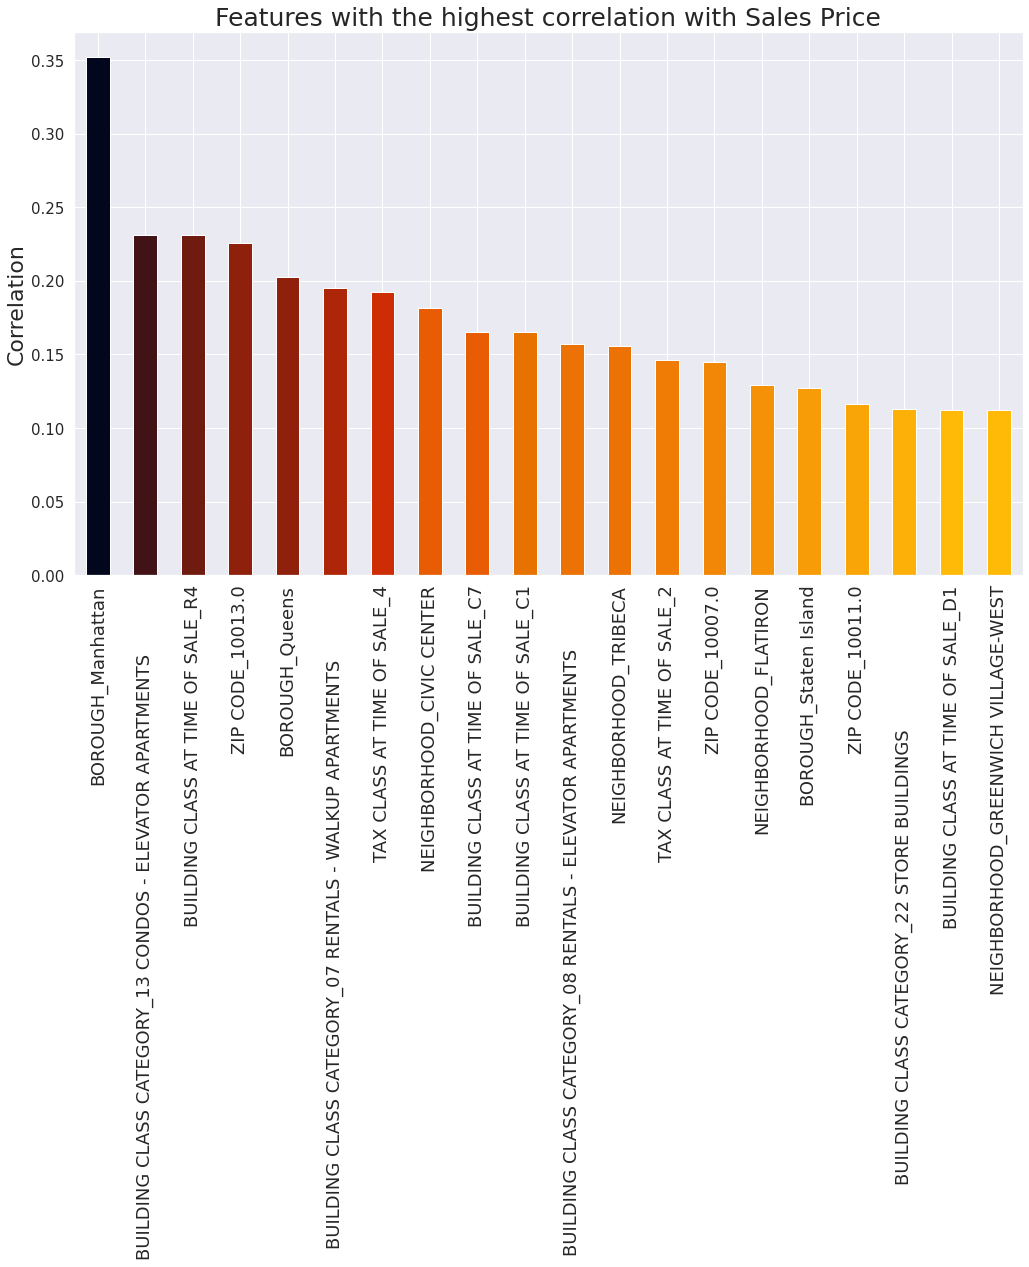

In [54]:
# Visualizing correlation between target feature 'Sale Price' and the features with highest correlation
plt.figure(figsize=(17, 10))

# Custom cmap with generated hexcodes from coolors.co
cmap = ['#03071E', '#411216', '#701B10', '#8F210C', '#8F210C', '#AE2608', 
        '#CD2C04', '#E85D04', '#E85D04', '#E87200', '#ED7205', '#ED7205', 
        '#F07C05', '#F28606', '#F59106', '#F79B07', '#FAA507', '#FCB008', 
        '#FFBA08', '#FFBA08']

# Calculate the correlation between all features (excluding SALE PRICE) and SALE PRICE,
# and select the 20 features that correlate the most
highest_corr = X_train.corrwith(y_train).abs().sort_values(ascending=False)[:20]

# Plot the correlations
highest_corr.plot(kind='bar', color=cmap)
# plt.invert_yaxis()
plt.tick_params(axis='x', labelsize=18)
plt.tick_params(axis='y', labelsize=15)
plt.ylabel("Correlation", fontsize=22)
plt.title("Features with the highest correlation with Sales Price", size=25)

plt.show()

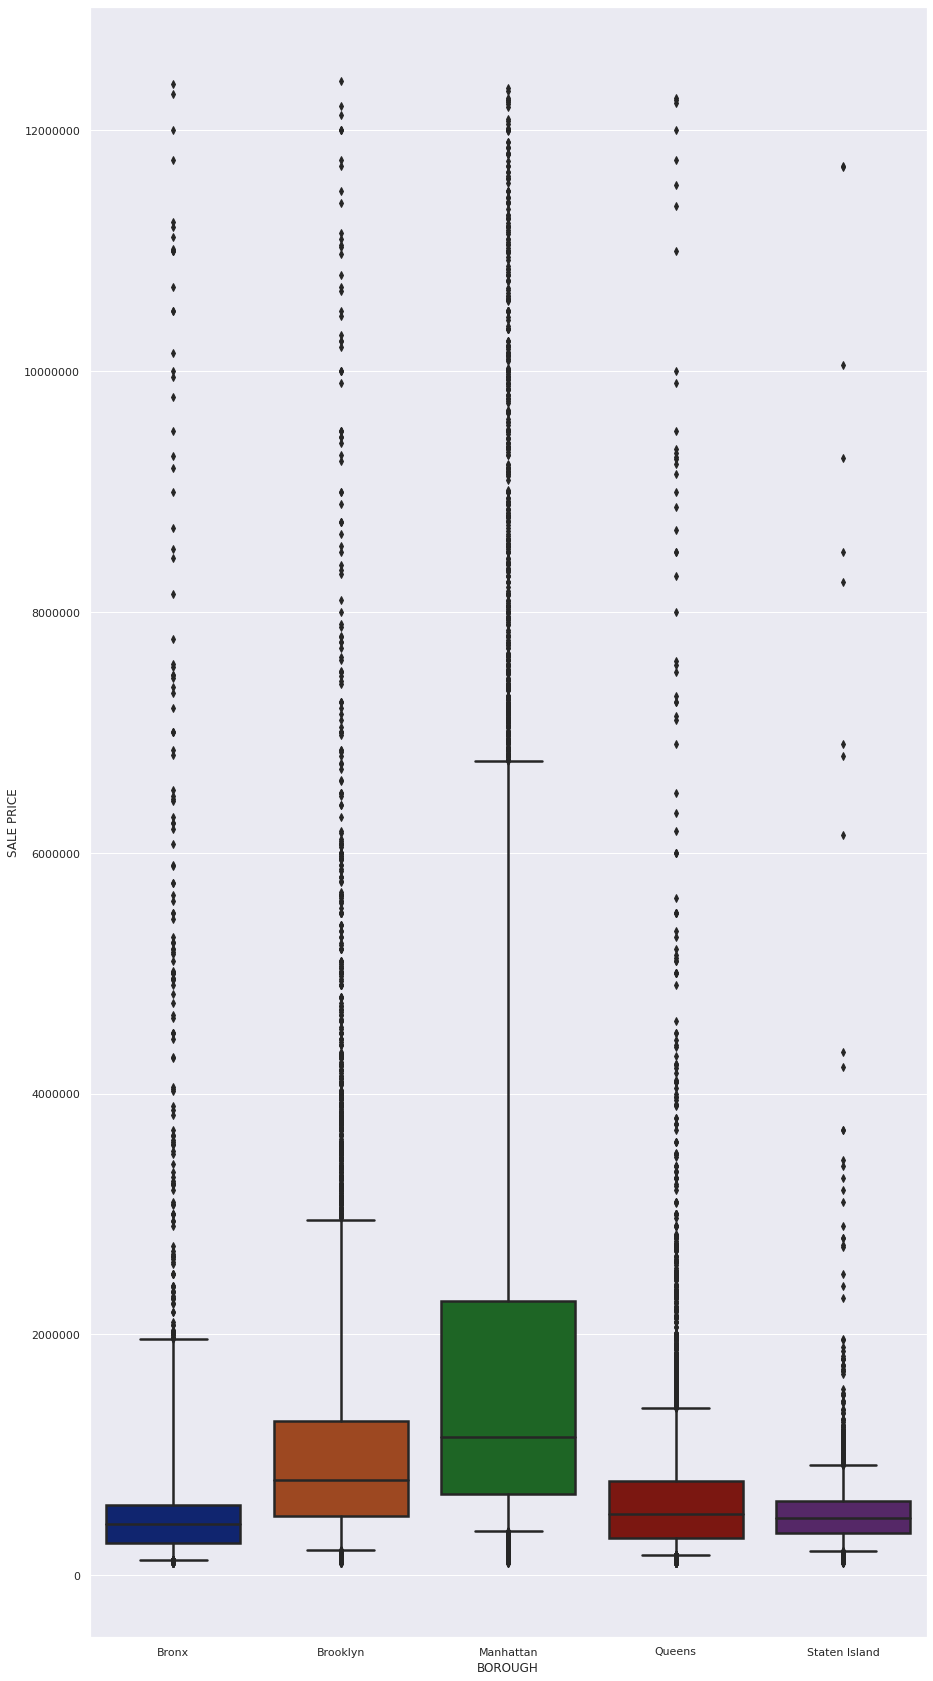

In [55]:
# Creating a boxplot for the sale price in each borough. 
plt.figure(figsize=(15,30))
sns.set(style='darkgrid', context='notebook', palette='coolwarm') 
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
plt.ticklabel_format(style='plain', axis='y')

# Concatenate X_train and y_train to a single dataframe with training data
Xy_train = pd.concat(objs=[X_train, y_train], axis=1)


# The interquartile range (the boxes) shows the quartiles. 
# whiskers are set to 5th and 95th percentiles
sns.boxplot(x='BOROUGH', y="SALE PRICE", data=Xy_train, palette='dark', whis=[5, 95])
plt.show()

In [56]:
# Remove the "BOROUGH" feature from the data, we no longer need it as it is one-hot encoded
X_train = X_train.drop("BOROUGH", axis=1)
X_val = X_val.drop("BOROUGH", axis=1)
X_test = X_test.drop("BOROUGH", axis=1)

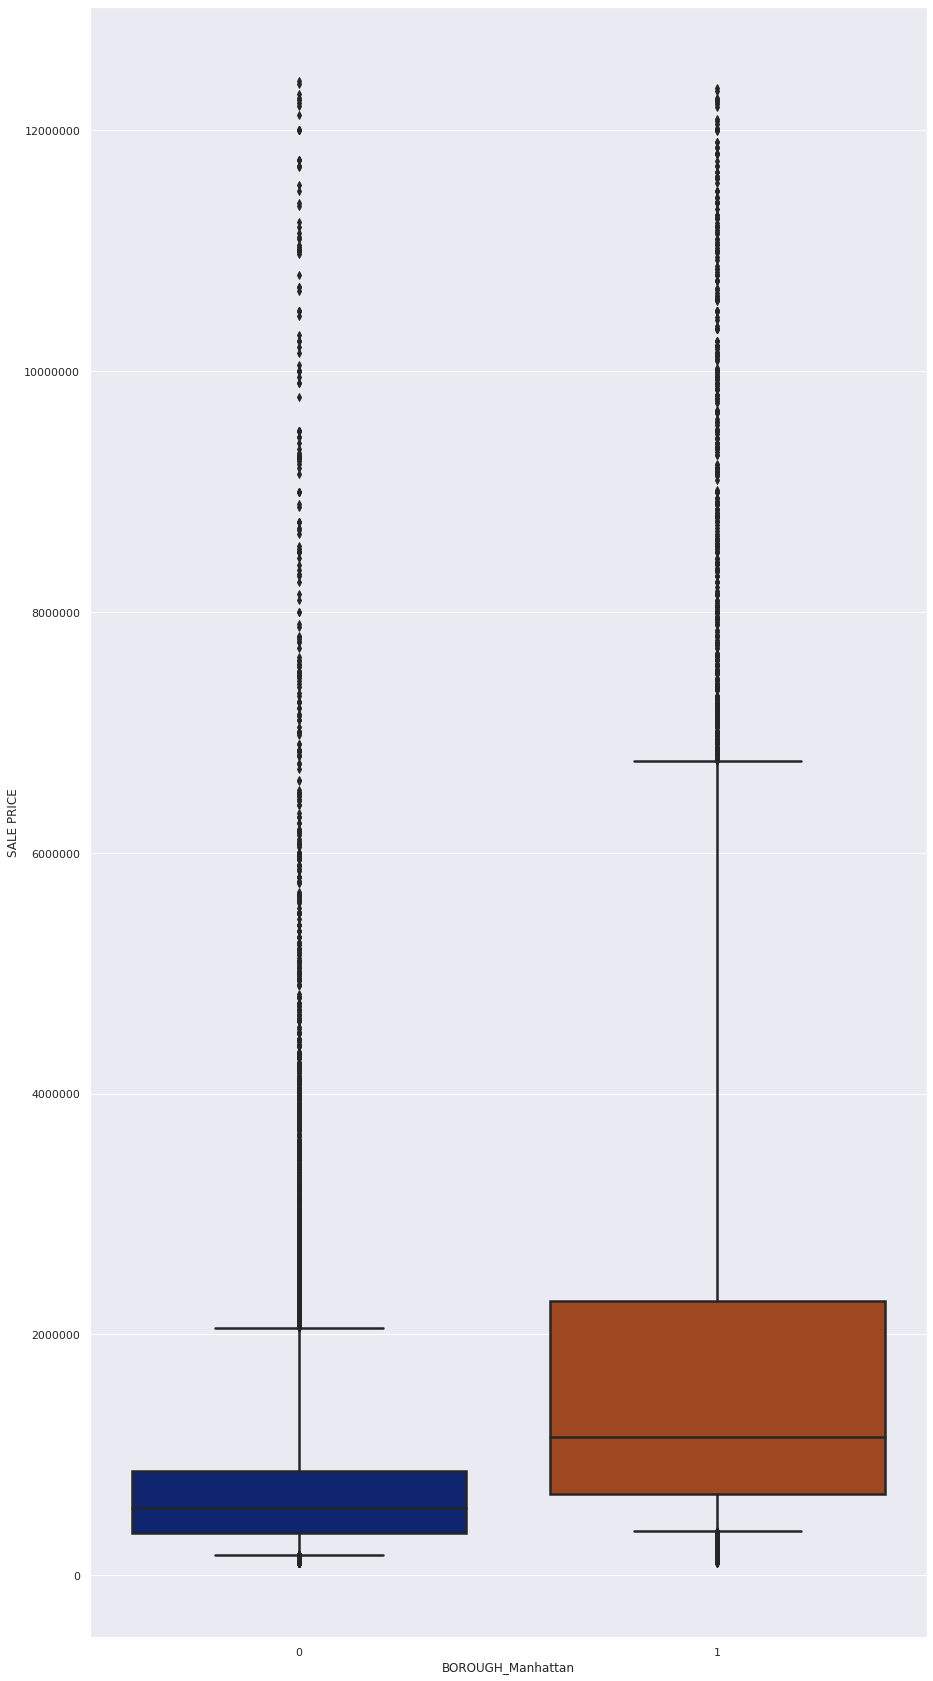

In [57]:
# Creating a boxplot for Borough = Manhattan vs rest. 
plt.figure(figsize=(15,30))
sns.set(style='darkgrid', context='notebook', palette='coolwarm') 
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
plt.ticklabel_format(style='plain', axis='y')

sns.boxplot(x='BOROUGH_Manhattan', y="SALE PRICE", data=Xy_train, palette='dark', whis=[5, 95])
plt.show()

The box plots above shows the distribution of sale price across the five different boroughs in New York. The clear variation in distribution for these different values indicate that the different `BOROUGH` features will be very important for making predictions. The second box plot also clear shows how much higher the sale prices are in Manhattan than the rest of the city, explaining why `BOROUGH_Manhattan` correlates the most with the target.

The boxes in the plot show the interquartile range, i.e the lower (25) and higher (75) percentiles with the median marked as a black line. The whiskers are set to the 5th and 95th percentile, so this plot clearly shows how many outliers we still have in our dataset.

#### <a id="distribution"></a>3.5) Visualizing the distribution of the target feature and the effect of scaling

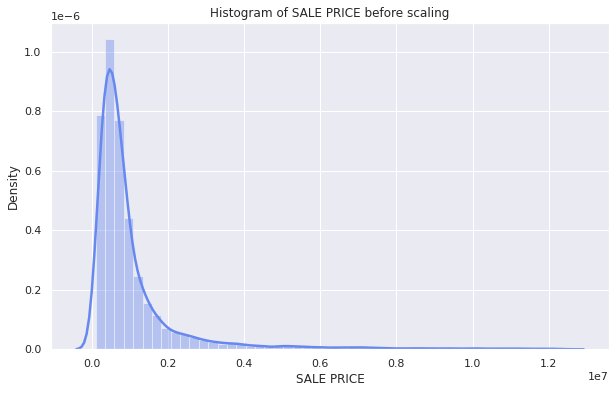

In [58]:
# Visualizing the target feature for the training data
plt.figure(figsize=(10,6))
sns.distplot(y_train)
plt.title('Histogram of SALE PRICE before scaling')
plt.show()

In [59]:
# Scaling a copy of the target feature for visualization purposes
scaler = MinMaxScaler()
y_train_copy = y_train.copy(deep=True)
y_train_copy = scaler.fit_transform(y_train_copy.values.reshape(-1, 1))

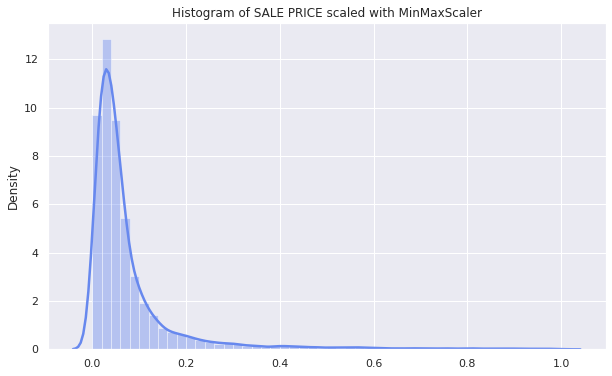

In [60]:
# Visualizing the scaled and transformed target feature (Training data)
plt.figure(figsize=(10,6))
sns.distplot(y_train_copy)
plt.title('Histogram of SALE PRICE scaled with MinMaxScaler')
plt.show()

In [61]:
# Scaling a copy of the target feature for visualization purposes
scaler = QuantileTransformer(output_distribution='normal')
y_train_copy = y_train.copy(deep=True)
y_train_copy = scaler.fit_transform(y_train_copy.values.reshape(-1, 1))
y_val_copy = y_val.copy(deep=True)
y_val_copy = scaler.transform(y_val_copy.values.reshape(-1, 1))

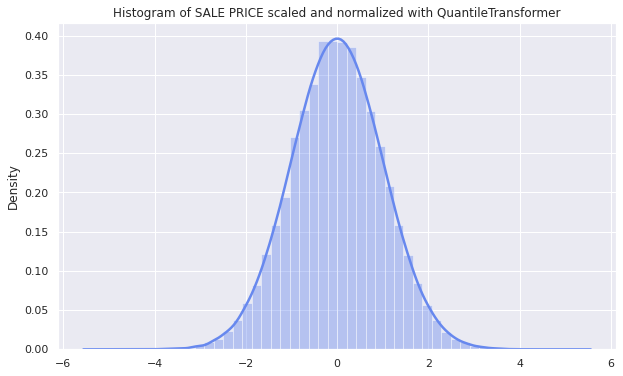

In [62]:
# Visualizing the scaled and transformed target feature (Training data)
plt.figure(figsize=(10,6))
sns.distplot(y_train_copy)
plt.title('Histogram of SALE PRICE scaled and normalized with QuantileTransformer')
plt.show()

We chose to use QuantileTransformer to scale and normalizing the data because it is very robust towards outliers and is simultaneously able to map the data to a Gaussian (Normal) distribution. The plot above shows that the training data has been mapped prefectly to a normal distribution, and has been scaled to a range between positive and negative 6.

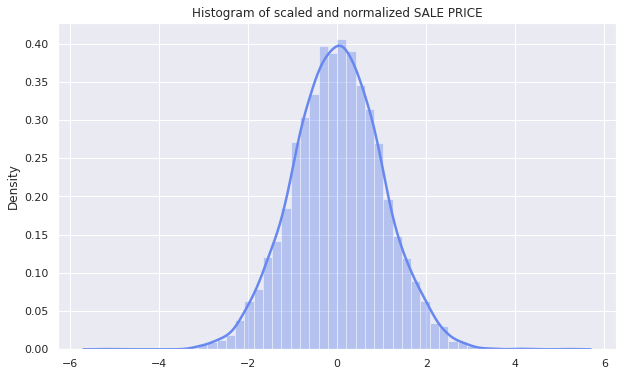

In [63]:
# Visualizing the scaled and transformed target feature (Validation data)
plt.figure(figsize=(10,6))
sns.distplot(y_val_copy)
plt.title('Histogram of scaled and normalized SALE PRICE')
plt.show()

However, since we are fitting the scaler on the training data and then using that scaler to transform the validation and test data, there might be a discrepancy in the distribution in the datasets used for evaluation. We can see from the plot above that the validation data isn't normalized perfectly. We should therefore expect slightly lower accuracy on the validation and test sets than on the training set, even when the models aren't overfitting. 

#### <a id="distribution"></a>3.6) Analyzing the effect of Principal Component Analysis on training data

Text(0, 0.5, 'Explained variance')

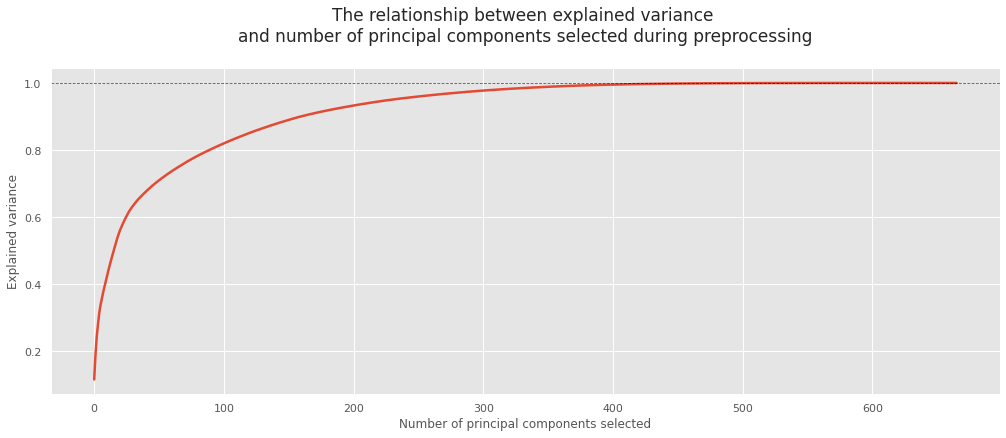

In [64]:
# PCA only works well with normalized data with zero mean and unit variance.
# We apply QuantileTransformer on a copy of the training data
scaler = QuantileTransformer(output_distribution='normal')
X_train_copy = X_train.copy(deep=True)
scaler.fit(X_train_copy)
X_train_copy_scaled = scaler.transform(X_train_copy)

pca = PCA()
p_components = pca.fit(X_train_copy_scaled)

# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
plt.figure(figsize=(17,6))
plt.style.use('ggplot')
plt.plot(np.cumsum(p_components.explained_variance_ratio_))
plt.axhline(1.0, ls='--', color='black', alpha=0.7, linewidth=0.8)
plt.title('The relationship between explained variance \nand number of principal components selected during preprocessing\n ', size=17)
plt.xlabel('Number of principal components selected')
plt.ylabel('Explained variance')

In [65]:
# Calculating the nth component which explains 100% of the variance in the data
cumsum = np.cumsum(p_components.explained_variance_ratio_)
indeces = range(0, len(cumsum)-1)
nth_component_var_lt_one = ([(variance, index) for variance, index in zip(cumsum, indeces) if round(variance, 15) < 1.0][-1:][0])
print(f"Total number of principal components: {len(cumsum)}")
print(nth_component_var_lt_one)
print(f"The {nth_component_var_lt_one[1]}th component explains {nth_component_var_lt_one[0]}% of the variance.")
print(f"The {nth_component_var_lt_one[1] + 1}th component explains 100% of the variance.")

Total number of principal components: 666
(0.9999999026353096, 567)
The 567th component explains 0.9999999026353096% of the variance.
The 568th component explains 100% of the variance.


Using 568 out of 666 principal components explains 100% of the variance in the training data. This means that we can significantly improve training time and reduce model complexity by adding PCA to the model pipelines.

## <a id="modelling"></a>4) Modelling

In [66]:
# Collective scaling for all models except XGBoost, which doesn't require scaling
scaler = QuantileTransformer(output_distribution = 'normal')

# Fit on X_train, transform X_val and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fit on y_train, transform y_val and y_test
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1,1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1,1))
y_test_scaled = scaler.transform(y_val.values.reshape(-1,1))

### <a id="linear-regression"></a>4.1) Linear Regression models

Predicting sales price is a supervised regression problem, as we want to predict a floating point number from a set of numerical features. We will start our machine learning modelling by running a family of different linear regression algorithms.

We think that these models will prove effective, because the correlation matrix plot in section 3.4 shows that there is a strong linear correlation between the features and sale price. Linear regression models all assume that there is a linear relationship between the features in the X data and the target feature in y, where the relationship is modelled as $Y=a+bX$.  *(Yale University, 2021)*

$Y$ is the dependent variable being measured, a is the intercept(the value of $y$ when $x = 0$), $b$ is the slope of the line and the $X$ is the explanatory variable that can be manipulated. 

Linear regression functions attempt to calculate a line that fits the data most closely. They use the Ordinary Least Squares methods, which is a way to minimize the sum of the deviations from each data point to the best fitting line.

As a baseline for the models, we start our process by running a standard Linear Regression algorithm with no regularization. Without any regularization parameters, Scikit-Learn's Linear Regression class does not have any parameters that require tuning, making it a quick and easy algorithm to run. We expect that the resulting linear regression model will underfit and not be able to capture the complexity and variation in the data.

In [65]:
# Create pipeline
linreg_pipe = make_pipeline(PCA(n_components=568), LinearRegression())     

# Training the model 
linreg_pipe.fit(X_train_scaled, y_train_scaled)

# Prediction on training data
linreg_train_predict = linreg_pipe.predict(X_train_scaled)
r2_trainpred = r2_score(y_train_scaled, linreg_train_predict)
print('R2 for predictions made on training data:', r2_trainpred)

# Prediction on validation data
linreg_val_predict = linreg_pipe.predict(X_val_scaled)
r2_valpred = linreg_pipe.score(X_val_scaled, y_val_scaled)
print('R2 for predictions made on validation data:', r2_valpred)

# Calculating the RMSE for predictions made on validation data
linreg_val_predict_unscaled = scaler.inverse_transform(linreg_val_predict)
print('RMSE', sqrt(mean_squared_error(y_val, linreg_val_predict_unscaled)))

R2 for predictions made on training data: 0.7289343484598279
R2 for predictions made on validation data: 0.7303729715773779
RMSE 952668.2155830787


Lasso performs both variable selection and regularization. Variable selection uses a subset of relevant features in construction of the model. Regularization shrinks some of the coefficient estimates to zero, thus removing some features. This works as a feature selection. This reduces complexity and prevents overfitting *(Gupta, P., 2017)*.

Grid search is used for tuning the parameters in the most optimal way. By testing different parameters with the function, grid search finds the best parameters. The cross validation evaluates the models on a limited data sample. When combining grid search and cross validation, you get a result that better reflects the model’s ability to generalize as the results are no longer sensitive to how the data is split.


In [66]:
pipe = make_pipeline(PCA(n_components=568), Lasso())     

# Parameter for Lasso with grid search
param_grid = [{
    'lasso__alpha': [1,0.1,0.01,0.001,0.0001, 0.00001,0]
    }]

# Run the grid search
lasso_gs = GridSearchCV(pipe, param_grid, n_jobs=-1)
lasso_gs.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=568, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                         

In [67]:
# Creating a Pandas DataFrame with the mean test scores for cross validation achieved during grid search
results = pd.DataFrame(lasso_gs.cv_results_)
mean_test_scores_result = pd.concat([results.param_lasso__alpha,
                                     results.mean_test_score], axis=1)
mean_test_scores_result.rename(columns={'mean_fit_time': 'mean_fit_time (s)', 
                                        'mean_test_score': 'mean_test_score (r2)'})
mean_test_scores_result.T

,0,1,2,3,4,5,6
param_lasso__alpha,1,0.1,0.01,0.001,0.0001,1e-05,0
mean_test_score,0.142383,0.435671,0.67578,0.712492,0.713778,0.713356,-2.16197e+22


In [68]:
# Display the optimal params and best scores achieved during search
print(f"Optimal parameters for Lasso: {lasso_gs.best_params_}")
print(f"Best cross validation r2 score achieved during grid search: {lasso_gs.best_score_}")

Optimal parameters for Lasso: {'lasso__alpha': 0.0001}
Best cross validation r2 score achieved during grid search: 0.7137777374356091


In [69]:
# Retrain Lasso model with best parameters
best_lasso = make_pipeline(PCA(n_components=568), Lasso(alpha = 0.0001))

# Training the model and measuring performance on training data
best_lasso.fit(X_train_scaled, y_train_scaled)
best_lasso_train_predict = best_lasso.predict(X_train_scaled)
r2_trainpred = r2_score(y_train_scaled, best_lasso_train_predict)
print('R2 training:', r2_trainpred)

# Calculating r2 for predictions made on validation data
best_lasso_val_predict = best_lasso.predict(X_val_scaled)
r2_valpred = r2_score(y_val_scaled, best_lasso_val_predict)
print('R2 for predictions made on validation data:', r2_valpred)

# Calculating the RMSE for predictions made on validation data
best_lasso_val_predict_unscaled = scaler.inverse_transform(best_lasso_val_predict.reshape(-1, 1))
print('RMSE', sqrt(mean_squared_error(y_val, best_lasso_val_predict_unscaled)))

R2 training: 0.728565789933135
R2 for predictions made on validation data: 0.7315228342016954
RMSE 951697.3594273095


In [70]:
# Retrieve the absolute feature weights with feature names
feature_weights = [(abs(weight), feature) for (weight, feature) in zip(best_lasso.named_steps['lasso'].coef_, X_train.columns)]

# Display the 10 features with highest absolute weights
print(f"10 features with highest weight: \n{sorted(feature_weights, reverse=True)[:10]}")

# Display the features with weight of 0
dropped_features = [feature for (weight, feature) in feature_weights if weight == 0.0]
print(f"\nFeatures with weights of 0: \n{dropped_features}")

10 features with highest weight: 
[(0.27624817459777296, 'BUILDING CLASS AT TIME OF SALE_GU'), (0.22942752288608612, 'BUILDING CLASS AT TIME OF SALE_HS'), (0.22513385421810672, 'BUILDING CLASS AT TIME OF SALE_HH'), (0.18681018196605562, 'BUILDING CLASS AT TIME OF SALE_I9'), (0.17486406289700077, 'BUILDING CLASS AT TIME OF SALE_I5'), (0.17042694865833946, 'BUILDING CLASS AT TIME OF SALE_G6'), (0.15571584423816898, 'BUILDING CLASS AT TIME OF SALE_I6'), (0.14710345812845568, 'BUILDING CLASS AT TIME OF SALE_G1'), (0.14610825177073408, 'BUILDING CLASS AT TIME OF SALE_A6'), (0.14206227329503618, 'ZIP CODE_11005.0')]

Features with weights of 0: 
['NEIGHBORHOOD_FRESH MEADOWS', 'BUILDING CLASS CATEGORY_25 LUXURY HOTELS                           ', 'ZIP CODE_11205.0', 'ZIP CODE_11220.0', 'ZIP CODE_11234.0', 'ZIP CODE_11361.0', 'ZIP CODE_11363.0', 'ZIP CODE_11413.0', 'ZIP CODE_11692.0', 'BUILDING CLASS AT TIME OF SALE_A1', 'BUILDING CLASS AT TIME OF SALE_A4', 'BUILDING CLASS AT TIME OF SALE_B9',

According to Lasso these features where the most important features, which can be confusing since they where not the features with the highest correlation initially. The reasoning for the result is that these buildings have a high price and are few in number, thus Lasso deeming their information important.  

Ridge uses L2 regularization, which is the sum of squares for all feature weights. L2 regularization forces the weights to be small, but does not make them zero like L1 regularization. Ridge keeps all the features and compresses the model. Ridge is best used on data that suffers with multicollinearity, which is when several variables are highly linearly related *(Great Learning Team, 2020)*. In our dataset we have removed variables with high correlation to each other, thus making this algorithm less effective.


In [71]:
pipe = make_pipeline(PCA(n_components=568), Ridge())     

# Parameter for Ridge with grid search
param_grid = [{
    'ridge__alpha': [1,0.1,0.01,0.001,0.0001]
    }]

# Run the grid search
ridge_gs = GridSearchCV(pipe, param_grid, n_jobs=-1)
ridge_gs.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=568, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('ridge',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'ridge__alpha': [1, 0.1, 0.01, 0.001, 0.0001]}],
          

In [72]:
# Creating a Pandas DataFrame with the mean test scores for cross validation achieved during grid search
results = pd.DataFrame(ridge_gs.cv_results_)
mean_test_scores_result = pd.concat([results.param_ridge__alpha,
                                     results.mean_test_score], axis=1)
mean_test_scores_result.rename(columns={'mean_fit_time': 'mean_fit_time (s)', 
                                        'mean_test_score': 'mean_test_score (r2)'})
mean_test_scores_result.T

,0,1,2,3,4
param_ridge__alpha,1,0.1,0.01,0.001,0.0001
mean_test_score,0.71336,0.713241,0.713218,0.713216,0.713216


In [73]:
# Display the optimal params and best scores achieved during search
print(f"Optimal parameters for Ridge: {ridge_gs.best_params_}")
print(f"Best cross validation r2 score achieved during grid search: {ridge_gs.best_score_}")

Optimal parameters for Ridge: {'ridge__alpha': 1}
Best cross validation r2 score achieved during grid search: 0.713359632534228


In [74]:
# Create Ridge model with optimal parameters found through grid search
ridge_pipe = make_pipeline(PCA(n_components=568), Ridge(alpha=1))  

# Training the model and measuring performance on training data
ridge_pipe.fit(X_train_scaled, y_train_scaled)
ridge_train_predict = ridge_pipe.predict(X_train_scaled)
r2_trainpred = r2_score(y_train_scaled, ridge_train_predict)
print('R2 training:', r2_trainpred)

# Calculating r2 for predictions made on validation data
ridge_val_predict = ridge_pipe.predict(X_val_scaled)
r2_valpred = r2_score(y_val_scaled, ridge_val_predict)
print('R2 for predictions made on validation data:', r2_valpred)

# Calculating the RMSE for predictions made on validation data
ridge_val_predict_unscaled = scaler.inverse_transform(ridge_val_predict.reshape(-1, 1))
print('RMSE', sqrt(mean_squared_error(y_val, ridge_val_predict_unscaled)))

R2 training: 0.728926295933108
R2 for predictions made on validation data: 0.7304414643246286
RMSE 952578.4876425536


ElasticNet combines L1 and L2 regularization linearly. The model performs both variable selection and regularization at the same time. L1 will remove features to avoid overfitting, and L2 will reduce the impact of features that are not important. By combining these, one aim to remove the disadvantages of both L1 and L2. The R2 score we got is higher than both Lasso and Ridge, proving that combining the two is effective.

In [75]:
# ElasticNet with PCA and grid search using a pipeline

# Create a pipeline to grid search for the best combination of 
# principal components and classifier regularization
pipe = make_pipeline(PCA(n_components=568), ElasticNet(max_iter=5000))

# Parameters for PCA and ElasticNet to be tuned with grid search
param_grid = [{
    'elasticnet__alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 1],
    'elasticnet__l1_ratio': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
    }]

# Run the grid search
elasticNet_gs = GridSearchCV(pipe, param_grid, n_jobs=-1)
elasticNet_gs.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=568, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('elasticnet',
                                        ElasticNet(alpha=1.0, copy_X=True,
                                                   fit_intercept=True,
                                                   l1_ratio=0.5, max_iter=5000,
                                                   normalize=False,
                                                   positive=False,
                                                   precompute=False,
                                                   random_state=None,
                        

In [76]:
# Creating a Pandas DataFrame with the mean test scores for cross validation achieved during grid search
results = pd.DataFrame(elasticNet_gs.cv_results_)
mean_test_scores_result = pd.concat([results.param_elasticnet__alpha, 
                                     results.param_elasticnet__l1_ratio, 
                                     results.mean_test_score], axis=1)
mean_test_scores_result.rename(columns={'mean_fit_time': 'mean_fit_time (s)', 
                                        'mean_test_score': 'mean_test_score (r2)'})
mean_test_scores_result.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
param_elasticnet__alpha,0.001,0.001,0.001,0.001,0.001,0.001,0.005,0.005,0.005,0.005,0.005,0.005,0.01,0.01,0.01,0.01,0.01,0.01,0.05,0.05,0.05,0.05,0.05,0.05,0.1,0.1,0.1,0.1,0.1,0.1,1,1,1,1,1,1
param_elasticnet__l1_ratio,0.001,0.01,0.05,0.1,0.2,0.3,0.001,0.01,0.05,0.1,0.2,0.3,0.001,0.01,0.05,0.1,0.2,0.3,0.001,0.01,0.05,0.1,0.2,0.3,0.001,0.01,0.05,0.1,0.2,0.3,0.001,0.01,0.05,0.1,0.2,0.3
mean_test_score,0.714015,0.714043,0.714132,0.714192,0.714229,0.714189,0.714755,0.714737,0.714465,0.713906,0.712227,0.710229,0.714794,0.714641,0.71362,0.711838,0.707731,0.703774,0.711878,0.710281,0.702004,0.691807,0.671322,0.649797,0.707061,0.7034,0.686498,0.665713,0.620959,0.577944,0.623428,0.590865,0.480271,0.418055,0.354,0.309148


In [67]:
# Function for plotting 2D heatmaps of quadratic shape
def plot_heatmap(values, xlabel, ylabel, xticklabels, yticklabels):
    ax = plt.gca()
    heatmap = ax.pcolor(values, cmap="RdBu")
    heatmap.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for path, color, value in zip(heatmap.get_paths(), 
                                  heatmap.get_facecolors(),
                                  heatmap.get_array()):
        x, y = path.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, "%0.3f" % value, color=c, 
                ha="center", va="center")
    
    return heatmap

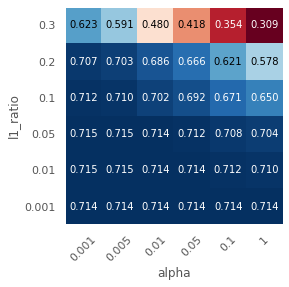

In [78]:
# Plot a 6x6 heatmap with the mean test scores during parameter tuning
scores = np.array(results.mean_test_score).reshape(6, 6)
plot_heatmap(scores, xlabel='alpha', xticklabels=param_grid[0]['elasticnet__alpha'], 
        ylabel="l1_ratio", yticklabels=param_grid[0]['elasticnet__l1_ratio'])

In [79]:
# Display the optimal params and best scores achieved during search
print(f"Optimal parameters for ElasticNet: {elasticNet_gs.best_params_}")
print(f"Best cross validation r2 score achieved during grid search: {elasticNet_gs.best_score_}")

Optimal parameters for ElasticNet: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.001}
Best cross validation r2 score achieved during grid search: 0.7147936637451242


In [80]:
# Retraining an optimal ElasticNet model with the parameters found by Grid Search
best_elasticnet = make_pipeline(PCA(n_components=568), 
                                ElasticNet(max_iter=5000, 
                                           alpha=0.01, l1_ratio=0.001))

# Calculate tuned model's R2 score for validation set
best_elasticnet.fit(X_train_scaled, y_train_scaled)
print(f"Tuned model's prediction r2 score on the validation set: {best_elasticnet.score(X_val_scaled, y_val_scaled)}")

# Calculating the RMSE for predictions made on validation data
elasticnet_y_pred = best_elasticnet.predict(X_val_scaled)
elasticnet_y_pred_reverted = scaler.inverse_transform(elasticnet_y_pred.reshape(-1, 1))
print(f'Retrained ElasticNet RMSE on validation data: {sqrt(mean_squared_error(y_val, elasticnet_y_pred_reverted))}')

Tuned model's prediction r2 score on the validation set: 0.732342611243657
Retrained ElasticNet RMSE on validation data: 950209.7516803422


ElasticNet prestert X, som var X ift forventet



### <a id="svm"></a>4.2) Support Vector Machines

The second type of machine learning algorithm we want to use is LinearSVR, as it is effective in high dimensional spaces. We originally wanted to use the standard SVR module with the RBF kernel. However, this algorithm struggles with datasets with more than 10,000 samples. On the other hand, while the RBF kernel has a quadratic time complexity, the liblinear kernel runs in exponential time instead. Its runtime in Big O notation is $O(n^2 - eps)$, where $n$ is number of samples *(Scikit-Learn developers, 2020)*.

Since the number of samples in our dataset is greater than the number of features, the `dual` parameter is set to "False". This means that the algorithm is working to solve the primal optimization problem. 

Decreasing the C parameter makes the algorithm adjust the majority of the data points to find a hyperplane with a larger-margin separation. Larger margins avoids overfitting and therefore potentially improves the accuracy of our regressor when predicting on unseen data. 


In [81]:
# LinearSVR pipeline with L2 as loss parameter 
pipe = make_pipeline(PCA(n_components=568), 
                     LinearSVR(random_state=random_state, tol=1e-5, max_iter=5000, 
                               dual=False, loss='squared_epsilon_insensitive'))     
# Parameters for GridSearch
param_grid = [{
    'linearsvr__C': [0.001, 0.005, 0.01, 0.1, 0.2],
    'pca__n_components': [460, 400, 530, 568, 600]
    }]
    
# Gridsearch and fitting
linearSVR_gs = GridSearchCV(pipe, param_grid,n_jobs=-1)
linearSVR_gs.fit(X_train_scaled, y_train_scaled)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=568, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('linearsvr',
                                        LinearSVR(C=1.0, dual=False,
                                                  epsilon=0.0,
                                                  fit_intercept=True,
                                                  intercept_scaling=1.0,
                                                  loss='squared_epsilon_insensitive',
                                                  max_iter=5000,
                                                  random_state=42, tol=1e-05,
                     

[{'linearsvr__C': [0.001, 0.005, 0.01, 0.1, 0.2], 'pca__n_components': [460, 400, 530, 568, 600]}]


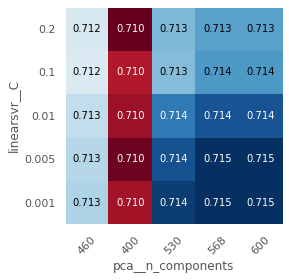

In [82]:
# Creating a Pandas DataFrame with the mean test scores for cross validation achieved during grid search
results = pd.DataFrame(linearSVR_gs.cv_results_)
mean_test_scores_result = pd.concat([results.param_pca__n_components, results.param_linearsvr__C, results.mean_test_score], axis=1)
mean_test_scores_result.rename(columns={'mean_fit_time': 'mean_fit_time (s)', 
                                        'mean_test_score': 'mean_test_score (r2)'})

# Plot a 5x5 heatmap with the mean test scores during parameter tuning
scores = np.array(results.mean_test_score).reshape(5, 5)
print(param_grid)
plot_heatmap(scores, xlabel='pca__n_components', xticklabels=param_grid[0]['pca__n_components'], 
        ylabel="linearsvr__C", yticklabels=param_grid[0]['linearsvr__C'])


In [83]:
print(f"Optimal parameters for LinearSVR: {linearSVR_gs.best_params_}")
print(f"Best cross validation r2 score achieved during grid search: {linearSVR_gs.best_score_}")

Optimal parameters for LinearSVR: {'linearsvr__C': 0.001, 'pca__n_components': 568}
Best cross validation r2 score achieved during grid search: 0.7145819765688348


By visualize the mean test scores from grid search, we see that the optimal parameters are `LinearSVR(C=0.001)` and `PCA(n_components=568)`. As expected, increasing the number of principal components to 600 had the same result as with 568. 


In [84]:
# Retraining an optimal Linear SVR model with the parameters found by Grid Search
best_SVR = make_pipeline(PCA(n_components=568), 
                     LinearSVR(random_state=random_state, tol=1e-5, max_iter=5000, 
                               dual=False, loss='squared_epsilon_insensitive', 
                               C=0.001))

# Calculate tuned model's R2 score for validation set
best_SVR.fit(X_train_scaled, y_train_scaled)
print(f"Tuned model's prediction r2 score on the validation set: {best_SVR.score(X_val_scaled, y_val_scaled)}")

# Calculating the RMSE for predictions made on validation data
SVR_y_pred = best_SVR.predict(X_val_scaled)
SVR_y_pred_reverted = scaler.inverse_transform(SVR_y_pred.reshape(-1, 1))
print(f'Retrained LinearSVR RMSE on validation data: {sqrt(mean_squared_error(y_val, SVR_y_pred_reverted))}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Tuned model's prediction r2 score on the validation set: 0.7319528914635642
Retrained LinearSVR RMSE on validation data: 951372.3195830275


### <a id="xgboost"></a>4.3) Gradient Boosting with XGBoost

We also decided to try XGBoost, which is a gradient boosting decision tree algorithm. This was due to hearing about it being fast and providing great results, and winning many kaggle competitions.

Although XGBoost uses decision trees and therefore should not be affected by scaling, we tried both with and without quantiletransformer - only to find that the normalization reduced the scoring by a few percentage points.
This probably happens as you lose some data when normalizing that xgboost could take advantage of.

The hyperparameters we found most imporant to try were: <br>
`max_depth`: Regularization technique controlling the depth of the tree. One thing to concider here is that deeper trees increase the chance of overfitting, while also increasing running time.

`learning_rate`: having a lower learning rate will make the model better in preventing overfitting. It does affect running time drastically though, being lower making it slower.

`min_child_weight`: a regularization technique at the splitting step. Using hessian weight in the creation of node.

`gamma`: another regularization technique for complexity control.

`colsample_bytree`: column subsampling to prevent overfitting. <br>
*(XGBoost developers, 2021)*

In [85]:
# Parameters for tuning
hparameters = {'max_depth': [3,5,7,9,11,13],
          'learning_rate': [0.05, 0.1, 0.15, 0.20, 0.25],
          'min_child_weight': [1,3,5,7,9],
          'gamma': [0.0,0.05,0.1,0.15,0.2,0.25],
          'colsample_bytree': [0.15,0.3,0.45,0.6]
}

To see the effect of the hyperparameters, we first tried to run the XGBRegressor with default values (except for having n_estimators set to 5000 with early-stopping), and thus creating a base-model to compare it with.

In [86]:
# Train a model on the training set with the BASE parameters 
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror', 
                         n_estimators = 5000)


xgb_r.fit(X_train, y_train, early_stopping_rounds=15, eval_set=[(X_val, y_val)]) 

[0]	validation_0-rmse:1.67243e+06
Will train until validation_0-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:1.57233e+06
[2]	validation_0-rmse:1.48599e+06
[3]	validation_0-rmse:1.41248e+06
[4]	validation_0-rmse:1.34807e+06
[5]	validation_0-rmse:1.29399e+06
[6]	validation_0-rmse:1.24679e+06
[7]	validation_0-rmse:1.2061e+06
[8]	validation_0-rmse:1.17151e+06
[9]	validation_0-rmse:1.14198e+06
[10]	validation_0-rmse:1.11258e+06
[11]	validation_0-rmse:1.08681e+06
[12]	validation_0-rmse:1.06469e+06
[13]	validation_0-rmse:1.04592e+06
[14]	validation_0-rmse:1.0309e+06
[15]	validation_0-rmse:1.018e+06
[16]	validation_0-rmse:1.00154e+06
[17]	validation_0-rmse:991264
[18]	validation_0-rmse:982571
[19]	validation_0-rmse:974510
[20]	validation_0-rmse:963414
[21]	validation_0-rmse:957388
[22]	validation_0-rmse:949983
[23]	validation_0-rmse:943767
[24]	validation_0-rmse:937071
[25]	validation_0-rmse:931378
[26]	validation_0-rmse:927455
[27]	validation_0-rmse:924150
[28]	validation_0-rmse:9

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [87]:
# Make PREDICTIONS 
pred_val = xgb_r.predict(X_val)
pred_train = xgb_r.predict(X_train)

# PREDICTION ON TRAIN SET
print("PREDICTION ON TRAIN SET")
rmse = (np.sqrt(mean_squared_error(y_train, pred_train)))
print(f"RMSE: {round(rmse,4)}") 
print("R2:",round(r2_score(y_train, pred_train),4), '\n')

# PREDICTION ON VAL SET
print("PREDICTION ON VAL SET")
rmse = (np.sqrt(mean_squared_error(y_val, pred_val)))
print(f"RMSE: {round(rmse,4)}") 
print("R2:",round(r2_score(y_val, pred_val),4))

PREDICTION ON TRAIN SET
RMSE: 657202.5962
R2: 0.7798


PREDICTION ON VAL SET
RMSE: 740072.1869
R2: 0.7321




For hyperparameter-tuning in XGBoost we decided to go with RandomizedSearchCV instead of GridSearchCV.
There are many hyperparameters and potential values in xgboost. If we were to use gridsearch here, the algorithm would run for *6x5x5x6x4 = 3600* different combinations, not counting the cross-validation and building of trees. This would be extremely time-consuming.

Although it would probably be best to use RandomizedSearchCV to narrow down the value range, before running with GridSearchCV on fewer values, we found that the score did not change significantly with the different values. After trying to manually set values that we though could be better (watching the best_params_ result), we ended up using the result presented further below.
Implementing early stopping (having the algorithm check the RMSE on the validation set for each tree), if the RMSE does not improve in 15 rounds, it will stop. Early stopping also reduces overfitting.


In [88]:
# Instanciate the XGBRegressor estimator
modell_1 = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 500)

In [ ]:
#OBS!: TAKES 120+ MIN TO RUN (Can skip, as we've presented a model with best params below)
#Can also change n_iter to 1 to test it. NB: The results will vary!. 

# #Instanciating the random search cross-validation. 
# random_search = RandomizedSearchCV(modell_1,
#                                    param_distributions = hparameters,
#                                    n_iter = 30,
#                                    scoring = 'neg_root_mean_squared_error',
#                                    cv = 5,
#                                    verbose = 3)

# random_search.fit(X_train, y_train,early_stopping_rounds=15,eval_set =[(X_val,y_val)], eval_metric="rmse")

# #Display the best estimator and parameters
# print("ESTIMATOR: ",random_search.best_estimator_,"\n BEST_PARAMS: ",random_search.best_params_)

In [90]:
# Best results from running RandomizedSearchCV with n_iter=30:
"""
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',                          
                         n_estimators = 500, 
                         min_child_weight =3, 
                         max_depth= 13, 
                         learning_rate= 0.05, 
                         gamma= 0.25, 
                         colsample_bytree= 0.6
                         """

"\nxgb_r = xgb.XGBRegressor(objective ='reg:squarederror',                          \n                         n_estimators = 500, \n                         min_child_weight =3, \n                         max_depth= 13, \n                         learning_rate= 0.05, \n                         gamma= 0.25, \n                         colsample_bytree= 0.6\n                         "

After running 5-fold RandomizedSearchCV with 30 iterators, we will run a final XGBoost model with the best parameters. We also increase the "n_estimators" to 5000 to ensure that the model reaches the lowest possible RMSE. 

In [72]:
# Train a new model on the training set with the best parameters 
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror', 
                         n_estimators = 5000, 
                         min_child_weight =3, 
                         max_depth= 13, 
                         learning_rate= 0.05, 
                         gamma= 0.25, 
                         colsample_bytree= 0.6)

xgb_r.fit(X_train, y_train, early_stopping_rounds=15, eval_set=[(X_val, y_val)]) 

[0]	validation_0-rmse:1.73438e+06
Will train until validation_0-rmse hasn't improved in 15 rounds.
[1]	validation_0-rmse:1.66737e+06
[2]	validation_0-rmse:1.60433e+06
[3]	validation_0-rmse:1.54151e+06
[4]	validation_0-rmse:1.48441e+06
[5]	validation_0-rmse:1.43317e+06
[6]	validation_0-rmse:1.39681e+06
[7]	validation_0-rmse:1.34646e+06
[8]	validation_0-rmse:1.3011e+06
[9]	validation_0-rmse:1.2636e+06
[10]	validation_0-rmse:1.22036e+06
[11]	validation_0-rmse:1.18467e+06
[12]	validation_0-rmse:1.15599e+06
[13]	validation_0-rmse:1.12108e+06
[14]	validation_0-rmse:1.09636e+06
[15]	validation_0-rmse:1.07296e+06
[16]	validation_0-rmse:1.04454e+06
[17]	validation_0-rmse:1.02072e+06
[18]	validation_0-rmse:999092
[19]	validation_0-rmse:982018
[20]	validation_0-rmse:961825
[21]	validation_0-rmse:945328
[22]	validation_0-rmse:930743
[23]	validation_0-rmse:913129
[24]	validation_0-rmse:893261
[25]	validation_0-rmse:878302
[26]	validation_0-rmse:862075
[27]	validation_0-rmse:850366
[28]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.25,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=13, min_child_weight=3, missing=None, n_estimators=5000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [73]:
# Make PREDICTIONS 
pred_val = xgb_r.predict(X_val)
pred_train = xgb_r.predict(X_train)

#PREDICTION ON TRAIN SET
print("PREDICTION ON TRAIN SET")
rmse = (np.sqrt(mean_squared_error(y_train, pred_train)))
print(f"RMSE: {round(rmse,4)}") 
print("R2:",round(r2_score(y_train, pred_train),4), '\n')

#PREDICTION ON VAL SET
print("PREDICTION ON VAL SET")
rmse = (np.sqrt(mean_squared_error(y_val, pred_val)))
print(f"RMSE: {round(rmse,4)}") 
print("R2:",round(r2_score(y_val, pred_val),4), '\n')

PREDICTION ON TRAIN SET
RMSE: 366020.3201
R2: 0.9319 

PREDICTION ON VAL SET
RMSE: 662525.8332
R2: 0.786 



The new model tuned with the best parameters found by the RandomizedSearchCV stopped at 131 iterations, resulting in an improvement in accuracy of ~0.05 on the validation set. The RMSE also improved significantly, from 740072 down to 662525.

In [76]:
# RMSE for the average saleprice on validation set for comparison purposes
verdi = sum(y_val)/len(y_val)
liste = [verdi for x in range(len(y_val))]
liste = np.array(liste)

avg = np.sqrt(mean_squared_error(y_val, liste))
print(f"RMSE for avg: {round(avg,2)}")

RMSE for avg: 1432089.66


XGBoost comes with an easy way to plot the feature importance of a trained model. Setting the importance_type to 'gain' is best to see the relative importance of each feature. The higher the value of this metric when compared to another feature, the higher the importance for generating a prediction.

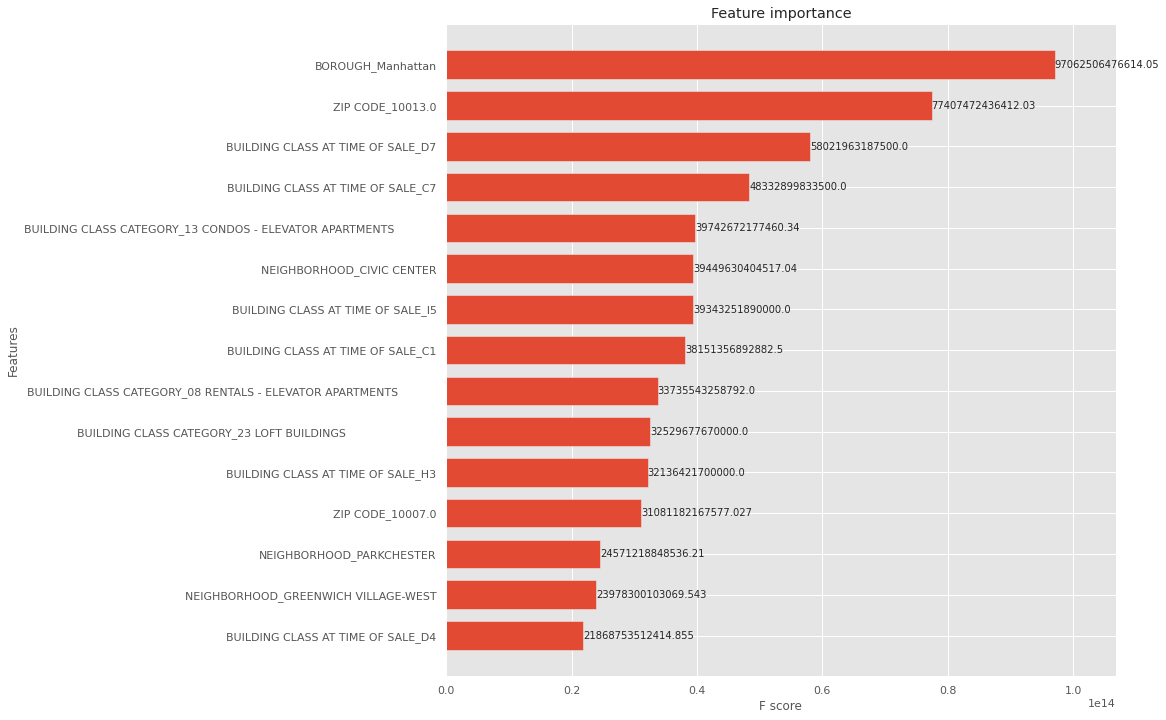

In [77]:
# SHOWING FEATURE IMPORTANCE: GAIN
fig, ax = plt.subplots(1,1,figsize=(12,12))
plot_importance(xgb_r, height = 0.7, max_num_features=15, ax=ax,importance_type='gain', show_values=True)

plt.show()

### <a id="mlp"></a>4.4) Neural Network: Multilayered Perceptron

The Multi-Layered Perceptron (MLP) is an artificial neural network that aggregates the results from multiple perceptrons, which are the atomic building blocks for neural networks. Scikit Learn's MLP Regressor estimator learns to depict the dependencies between the input (X_train) and output (y_train) using a weighted linear summation between the different layers of perceptrons. Training requires the adjustment of parameters of the model through backpropogation. It is important to note that since the layers in the estimator are non-linear, and that each perceptron in a layer is independent from every other perceptron in that layer, the MLP regressor is able to learn non-linear relationships between input and output data. 

The activation function in the output layer uses the square error as the loss function, so that the model can produce a set of continuous values as output. For this project, we decided to use a Rectified Non-Linear Unit (ReLU) as an activation function in the output layer, which is a simple linear function that also ensures that outputs are non-negative. ReLU is easy to train and often performs quite well, especially when the behaviour of the network is linear. ReLU also avoids the problem of vanishing gradients. 

The advantage of the MLP Regressor is that it is capable of learning non-linear models. However, as with all neural networks, the MLP Regressor requires careful scaling and normalization of both the input data and the regression target. We will therefore be using the data which has been scaled and normalized with the QuantileTransformer. 

There are several other challenges to consider when training the MLP Regressor. Since the New York Housing dataset is complex with a lot of features, we want to carefully tune the parameters `hidden_layer_sizes` which controls network complexity and `alpha` which specifies the L2 regularization. Neural networks are prone to overfitting, so using regularization will combat this by penalizing weights with large magnitudes. 

We will also be using "Adam" as the solver, which is a stochastic optimizer that automatically adjusts how much the model updates parameters. Adam is robust when training on large datasets, and tends to converge quickly without compromizing the model's performance. However, as Adam uses gradient descent, the regressor will have a non-convex loss function where there exists more than one local minimum. This means that training the same estimator with the same training data can lead to different results, because random weight initialization can lead to diffent optima and thus different accuracies for validation data. 

Finally, the MLP Regressor also struggles with a high time complexity due to the number of different parameters that need to be learned. We expect that tuning parameters with GridSearchCV will be very time-consuming, so we will have to experiment carefully.

In [70]:
# Creating the pipeline. Instanciating the MLPRegressor class as an MLP model object.
# Setting static parameters for the algorithm
mlp_r_pipe = make_pipeline(PCA(n_components=568), 
                         MLPRegressor(activation='relu', solver='adam', 
                                      batch_size='auto', learning_rate='constant', 
                                      learning_rate_init=0.001, random_state=random_state))

# Tuning the parameters (hidden layers, regulization) 
# using grid search with cross-validation
params = {"mlpregressor__hidden_layer_sizes": [(75, 75), (100, 100), (25, 25, 25), 
                                               (50, 50, 50), (75, 75, 75)], 
          "mlpregressor__alpha": [0.01, 0.1, 0.5, 0.8, 1]}

mlp_r_gs = GridSearchCV(mlp_r_pipe, params, cv=3, n_jobs=-1, scoring='r2')

# Fitting and returning an tuned MLPRegressor model
mlp_r_gs.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=568, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('mlpregressor',
                                        MLPRegressor(activation='relu',
                                                     alpha=0.0001,
                                                     batch_size='auto',
                                                     beta_1=0.9, beta_2=0.999,
                                                     early_stopping=False,
                                                     epsilon=1e-08,
                                                     hidden_layer_sizes=(10...
             

In [71]:
# Printing the results from the grid search with cross-validation
results = pd.DataFrame(mlp_r_gs.cv_results_)
mean_test_scores_result = pd.concat([results.mean_fit_time, results.param_mlpregressor__alpha, 
                                     results.param_mlpregressor__hidden_layer_sizes, 
                                     results.mean_test_score], axis=1)
mean_test_scores_result.rename(columns={'mean_fit_time': 'mean_fit_time (s)', 
                                        'mean_test_score': 'mean_test_score (r2)'})
mean_test_scores_result.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
mean_fit_time,142.075,198.688,86.5081,116.39,175.002,183.117,206.757,80.0102,115.87,200.522,138.737,164.092,69.8906,92.5838,160.757,99.809,129.965,53.4253,103.035,113.552,112.041,121.762,60.0445,101.142,119.048
param_mlpregressor__alpha,0.01,0.01,0.01,0.01,0.01,0.1,0.1,0.1,0.1,0.1,0.5,0.5,0.5,0.5,0.5,0.8,0.8,0.8,0.8,0.8,1,1,1,1,1
param_mlpregressor__hidden_layer_sizes,"(75, 75)","(100, 100)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(75, 75)","(100, 100)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(75, 75)","(100, 100)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(75, 75)","(100, 100)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(75, 75)","(100, 100)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)"
mean_test_score,0.683878,0.694827,0.693049,0.677448,0.694574,0.722458,0.728435,0.729945,0.720772,0.729577,0.747166,0.746662,0.752147,0.747504,0.745573,0.75518,0.755705,0.75864,0.75598,0.756113,0.75707,0.757504,0.760123,0.759628,0.757445


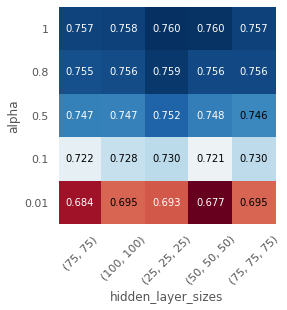

In [72]:
# Plot a 5x5 heatmap with the mean test scores during parameter tuning
scores = np.array(results.mean_test_score).reshape(5, 5)

plot_heatmap(scores, xlabel='hidden_layer_sizes', 
             xticklabels=params['mlpregressor__hidden_layer_sizes'], 
             ylabel="alpha", yticklabels=params['mlpregressor__alpha'])

In [73]:
print(f"MLP Regressor best params found during grid search: {mlp_r_gs.best_params_}")
print(f"Best cross validation r2 score achieved during grid search: {mlp_r_gs.best_score_}")

MLP Regressor best params found during grid search: {'mlpregressor__alpha': 1, 'mlpregressor__hidden_layer_sizes': (25, 25, 25)}
Best cross validation r2 score achieved during grid search: 0.760122537308869


Looking at the heatmap for the grid search, we see that the highest scores are located near the edges of the grid. This indicates that the parameter values selected for the search have not been optimal.

In [68]:
# Creating the pipeline. Instanciating the MLPRegressor class as an MLP model object.
# Setting static parameters for the algorithm
mlp_r_pipe = make_pipeline(PCA(n_components=568), 
                         MLPRegressor(activation='relu', solver='adam', 
                                      batch_size='auto', learning_rate='constant', 
                                      learning_rate_init=0.001, random_state=random_state))

# Tuning the parameters again (hidden layers, regularization)
# using grid search with cross-validation
params = {"mlpregressor__hidden_layer_sizes": [(25, 25, 25), 
                                               (50, 50, 50), 
                                               (75, 75, 75), 
                                               (100, 100, 100), 
                                               (25, 25, 25, 25), 
                                               (50, 50, 50, 50)], 
          "mlpregressor__alpha": [1, 1.2, 1.4, 1.6, 1.8, 2.0]}

mlp_r_gs = GridSearchCV(mlp_r_pipe, params, cv=3, n_jobs=-1, scoring='r2')

# Fitting and returning an tuned MLPRegressor model
mlp_r_gs.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=568, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('mlpregressor',
                                        MLPRegressor(activation='relu',
                                                     alpha=0.0001,
                                                     batch_size='auto',
                                                     beta_1=0.9, beta_2=0.999,
                                                     early_stopping=False,
                                                     epsilon=1e-08,
                                                     hidden_layer_sizes=(10...
             

In [69]:
# Printing the results from the grid search with cross-validation
results = pd.DataFrame(mlp_r_gs.cv_results_)
mean_test_scores_result = pd.concat([results.mean_fit_time, results.param_mlpregressor__alpha, 
                                     results.param_mlpregressor__hidden_layer_sizes, 
                                     results.mean_test_score], axis=1)
mean_test_scores_result.rename(columns={'mean_fit_time': 'mean_fit_time (s)', 
                                        'mean_test_score': 'mean_test_score (r2)'})
mean_test_scores_result.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35
mean_fit_time,62.2193,92.1595,109.655,181.433,63.5987,93.0937,50.5807,104.892,127.029,150.554,56.7753,96.7351,47.6854,76.1759,114.222,124.025,54.5985,88.1246,42.8055,66.1308,111.584,133.076,48.9121,81.785,40.1475,73.1176,98.9714,128.875,55.197,88.9019,42.6443,65.1117,98.9805,110.03,50.0454,75.5647
param_mlpregressor__alpha,1,1,1,1,1,1,1.2,1.2,1.2,1.2,1.2,1.2,1.4,1.4,1.4,1.4,1.4,1.4,1.6,1.6,1.6,1.6,1.6,1.6,1.8,1.8,1.8,1.8,1.8,1.8,2,2,2,2,2,2
param_mlpregressor__hidden_layer_sizes,"(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(100, 100, 100)","(25, 25, 25, 25)","(50, 50, 50, 50)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(100, 100, 100)","(25, 25, 25, 25)","(50, 50, 50, 50)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(100, 100, 100)","(25, 25, 25, 25)","(50, 50, 50, 50)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(100, 100, 100)","(25, 25, 25, 25)","(50, 50, 50, 50)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(100, 100, 100)","(25, 25, 25, 25)","(50, 50, 50, 50)","(25, 25, 25)","(50, 50, 50)","(75, 75, 75)","(100, 100, 100)","(25, 25, 25, 25)","(50, 50, 50, 50)"
mean_test_score,0.760123,0.759628,0.757445,0.757056,0.75785,0.758813,0.759209,0.759266,0.759452,0.759243,0.761509,0.76016,0.761324,0.76167,0.760352,0.76078,0.761142,0.757069,0.761592,0.762746,0.762436,0.763864,0.761518,0.758978,0.764325,0.761894,0.763011,0.762996,0.755195,0.759533,0.763332,0.760935,0.762253,0.762122,0.761589,0.760593


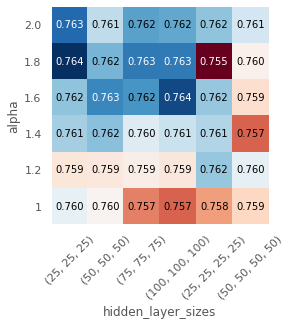

In [71]:
# Plot a 6x6 heatmap with the mean test scores during parameter tuning
scores = np.array(results.mean_test_score).reshape(6, 6)
plot_heatmap(scores, xlabel='hidden_layer_sizes', xticklabels=params['mlpregressor__hidden_layer_sizes'], 
        ylabel="alpha", yticklabels=params['mlpregressor__alpha'])

In [70]:
print(f"Optimal parameters for MLP Regressor: {mlp_r_gs.best_params_}")
print(f"Best cross validation r2 score achieved during grid search: {mlp_r_gs.best_score_}")

Optimal parameters for MLP Regressor: {'mlpregressor__alpha': 1.8, 'mlpregressor__hidden_layer_sizes': (25, 25, 25)}
Best cross validation r2 score achieved during grid search: 0.7643254385082704


In [74]:
# Retraining an optimal MLP Regression model for the best parameters
best_MLP = make_pipeline(PCA(n_components=568), 
                         MLPRegressor(activation='relu', solver='adam', 
                                      batch_size='auto', learning_rate='constant', 
                                      learning_rate_init=0.001, random_state=random_state, 
                                      hidden_layer_sizes=(25, 25, 25), alpha=1.8))

best_MLP.fit(X_train_scaled, y_train_scaled)
print(f"Tuned model's prediction r2 score on the validation set: {best_MLP.score(X_val_scaled, y_val_scaled)}")

Tuned model's prediction r2 score on the validation set: 0.7826625917548009


In [75]:
# Calculating the RMSE for predictions made on validation data
MLP_y_pred = best_MLP.predict(X_val_scaled)
MLP_y_pred_reverted = scaler.inverse_transform(MLP_y_pred.reshape(-1, 1))
print(f'MLP Regressor RMSE on validation data: {sqrt(mean_squared_error(y_val, MLP_y_pred_reverted))}')

MLP Regressor RMSE on validation data: 909797.4314882798


The final results for the MLP Regressor model is an accuracy ($R^2$) of 0.7827 and an RMSE of 909797. While the model is quite accurate, it is disappointing to see a RMSE that is much higher than we expected. This is likely because the model is struggling to predict on outliers, in particular those with a very high value for the sale price feature. Imperfect predictions made on these samples will increase RMSE by a lot more than imperfect predictions made on samples with a lower sale price. 

We expected a neural network to be able to capture the complexity of the dataset without overfitting. However, the XGBoost model has surprised us by outperforming all other models, including the neural network. We will therefore conclude the project by running XGBoost on the test set. 

## <a id="test-eval"></a>5) Final Evaluations and Conclusions

Since the parameter `eval_set` takes a dataset which is used to evaluate when the XGBoost model should stop training, we cannot retrain an XGBoost model on both training and validation data before testing on the test data. We still need to use validation data as the `eval_set`. This also means that the accuracy we got earlier when testing on the validation data wasn't completely unbiased, as the validation data was used to determine how long the model should be trained. We are therefore excited to see the final result. 


In [78]:
# XGBoost prediction on test set
pred_test = xgb_r.predict(X_test)

# Display predictions
print("PREDICTION ON TEST SET")
print("R2:",round(r2_score(y_test, pred_test),4))

# Calculate RMSE
rmse = (np.sqrt(mean_squared_error(y_test, pred_test)))
print(f"RMSE: {round(rmse,4)}") 

PREDICTION ON TEST SET
R2: 0.7791
RMSE: 634963.9721


We are impressed with the final results, as an $R^2$ of 0.7791 shows that the model was able to accurately capture the complexity in this difficult dataset. However, the RMSE indicates that this model shouldn't be used to predict house prices in the real estate industry anytime soon. One way of significantly improving the model would be to collect a large amount of data about a smaller domain - for example only price data for residential properties that were sold for prices in the range 300,000 - 4,000,000 dollars - and then train the model on that. 

The fact that the XGBoost model was more accurate than all of the other models we tried is interesting. XGBoost is an algorithm that is much easier to interpret than SVM or neural networks, and the XGBoost library makes communicating the results very easy by providing the `plot_importance` function. The final result speaks to the fact that XGBoost has contributed to numerous victories in machine learning competitions since its inception in 2016 *(Morde, V., 2019; Nielsen, D., 2016)*, and why it is becoming widely used in cutting edge applications in industry. 

## <a id="ref"></a>6) References

Yale University (2021). Linear Regression. Retrieved May 9, 2021 from: http://www.stat.yale.edu/Courses/1997-98/101/linreg.htm

Gupta, P (2017, Nov 15). Regularization in Machine Learning.  Retrieved May 10, 2021 from: https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a

Great Learning team (2020, Oct 15). What is Ridge Regression. Retrieved May 10, 2021 from: https://www.mygreatlearning.com/blog/what-is-ridge-regression/

Scikit-Learn Developers (2021). LinearSVR. Retrieved May 10, 2021 from:    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html

XGBoost developers (2020). Retrieved May 10, 2021 from:   https://xgboost.readthedocs.io/en/latest/python/python_api.html

Koehrsen, W (2018, Jan 10). Hyperparameter Tuning the Random Forest in Python. Retrieved May 10, 2020, from:                                                                 https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

Brownlee, J (2020, Aug 27). Avoid Overfitting By Early Stopping With XGBoost In Python. Retrieved May 10, 2021 from:                                                                   https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

Abu-Rmileh, A (2019, Feb 08). The Multiple faces of ‘Feature importance’ in XGBoost. Retrieved May 10, 2020, from: https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

Morde, V. (2019). XGBoost Algorithm: Long May She Reign! Retrieved May 10, 2021 from: https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

Nielsen, D. (2016). Tree Boosting With XGBoost - Why Does XGBoost Win "Every" Machine Learning Competition? Retrieved May 10, 2021 from: https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/2433761

